# Release Notes

    这个部分就作为版本记录吧。记录这个版本来自于哪一个版本。 

上一个版本：3.10-FeatureEngineering-MyFEPlan-1129。

删了一些没用的代码。





# Setting working directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/TrafficAccidentClaimsReview')

# Importing libraries and load datasets

In [3]:
## 安装catboost和lightgbm。
## catboost耗费显存极大，但是飞快；lightgbm好像不是那么的方便，gpu使用不起来。
!pip install catboost
# !pip uninstall lightgbm
# !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

     |████████████████████████████████| 66.3MB 71kB/s 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, average_precision_score
from sklearn.ensemble import RandomForestClassifier
# import tqdm
warnings.filterwarnings('ignore')

In [5]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/TrafficAccidentClaimsReview')

# Starting feature engineering

## Load dataset

In [57]:
data_train = pd.read_csv('originalDataset/train.csv')
data_test_a = pd.read_csv('originalDataset/test.csv')

## Numerical features and category features

In [ ]:
category_fea = list(data_train.select_dtypes(exclude=['object']).columns)
label = 'Evaluation'
category_fea.remove(label)
category_fea.remove("CaseId")

In [ ]:
#过滤数值型类别特征
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(data_train,category_fea)

In [ ]:
numerical_noserial_fea

['Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q5',
 'Q6',
 'Q7',
 'Q8',
 'Q9',
 'Q10',
 'Q11',
 'Q12',
 'Q13',
 'Q14',
 'Q15',
 'Q16',
 'Q17',
 'Q18',
 'Q19',
 'Q20',
 'Q21',
 'Q22',
 'Q23',
 'Q26',
 'Q28',
 'Q30',
 'Q32',
 'Q34',
 'Q35',
 'Q36']

In [ ]:
numerical_serial_fea

['Q24', 'Q25', 'Q27', 'Q29', 'Q31', 'Q33']

In [ ]:
# category_fea

In [ ]:
# #过滤数值型类别特征
# def get_numerical_serial_fea(data,feas):
#     numerical_serial_fea = []
#     numerical_noserial_fea = []
#     for fea in feas:
#         temp = data[fea].nunique()
#         if temp <= 10:
#             numerical_noserial_fea.append(fea)
#             continue
#         numerical_serial_fea.append(fea)
#     return numerical_serial_fea,numerical_noserial_fea
# numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(data_train,numerical_fea)

In [ ]:
# numerical_fea

In [ ]:
# numerical_noserial_fea

In [ ]:
# category_fea

## Classify the features into multiple categories

In [ ]:
data_train.nunique()

CaseId        200000
Q1                 4
Q2                 4
Q3                 4
Q4                 4
Q5                 4
Q6                 7
Q7                 7
Q8                 9
Q9                 5
Q10                6
Q11                4
Q12                4
Q13                3
Q14                3
Q15                3
Q16                5
Q17                4
Q18                4
Q19                5
Q20                3
Q21                4
Q22                4
Q23                8
Q24               36
Q25               43
Q26                4
Q27               15
Q28                5
Q29               53
Q30                4
Q31               43
Q32                4
Q33               39
Q34                2
Q35                2
Q36                2
Evaluation         2
dtype: int64

In [32]:
total_list = sorted(list(data_train.columns))

In [ ]:
numerical_category_fewValues = [
    "homeOwnership", 
    "verificationStatus",
    "initialListStatus",
    "applicationType",
    "n11",
    "n12",
]

In [ ]:
numerical_category_manyValues = [
    "regionCode",
    "employmentTitle",
    "purpose",
    "postCode",
    "title",
]

In [ ]:
date_type = [
    "issueDate", 
    "earliesCreditLine"
]

In [ ]:
numerical_serial = [
    "loanAmnt","interestRate","installment","annualIncome","dti","delinquency_2years","ficoRangeLow","ficoRangeHigh","openAcc",
    "pubRec","pubRecBankruptcies","revolBal","revolUtil","totalAcc","n0","n1","n2","n3",
    "n4","n5","n6","n7","n8","n9","n10","n13","n14",
    "term", 
]

In [ ]:
object_serial = [
    "grade",
    "subGrade", 
    "employmentLength"
]

In [ ]:
# len(numerical_category_fewValues) + len(numerical_category_manyValues) + len(date_type) + len(numerical_serial) + len(object_serial)
new_cates = numerical_category_fewValues + numerical_category_manyValues + date_type + numerical_serial + object_serial

In [ ]:
set(total_list) - set(new_cates)

{'id', 'isDefault', 'policyCode'}

In [ ]:
# data_train = data_train.head(200)
# data_test_a = data_test_a.head(200)

## Fill the null. 

**Mind this**: Some other filling schemes can be used. 

In [ ]:
# data_train.isnull().sum()

In [ ]:
# data_train["n14"].head()

In [ ]:
## Change the infinite number into NaN. 
# data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
# data_test_a.replace([np.inf, -np.inf], np.nan, inplace=True)

Lagrange interpolation

In [ ]:
# 创建函数，做插值，以空值前后5个数据（共10个数据）为例做插值  
from scipy.interpolate import lagrange  

## https://www.programmersought.com/article/37145216331/
def fillNanWithLagr(col,nv=-1,k=3):
    # col "fill column vector", nv "empty value, default -1", k "Lagrangian interval, default 3"
    # Get the null position
    if nv is np.nan:
        tar = col[col.isnull()].index.tolist()
    else:
        tar = col[col==nv].index.tolist()

    for idx in tqdm.tqdm(tar, position=0, leave=True):
      ## you can also use tqdm.tqdm_notebook(). The graphic info is more beautiful. 
    # for idx in tqdm.tqdm(tar):
                # Get Lagrange interval
                # The empty value position is removed here, because the filled empty value cannot be used to calculate other empty values
        # print(idx, end="")
        rel = col.iloc[
            list(
                set(list(range(idx-k,idx))+list(range(idx+1,idx+k+1))).difference(set(tar))
            )
        ]
                # Keep a reasonable range
        rel = rel[rel>=0][rel<len(col)]
                # Fill in Lagrangian mean
        # lagrange(arg1,arg2)(arg3)
                # arg1 "Iterable object index", arg2 "Iterable object conversion table", arg3 "Fill position"
        col.iloc[idx] = lagrange(rel.index,list(rel))(idx)
    return col

In [ ]:
# # data_train_cp = data_train.copy()
# # data_test_a_cp = data_test_a.copy()

# for i, data in enumerate([data_train, data_test_a]):
#     print("in the {} dataset:".format(i + 1))
#     for fea in numerical_fea:
#         if fea == "id":
#             continue
#         print(fea)
#         data[fea] = fillNanWithLagr(data[fea], np.nan, 5)

In [ ]:
# data_train.to_csv("preprocessedData/lagrangeInterpolated_train.csv", index=False)
# data_test_a.to_csv("preprocessedData/lagrangeInterpolated_test.csv", index=False)

Median interpolation

In [ ]:
# #按照平均数填充数值型特征
# data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
# data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna(data_train[numerical_fea].median())
# #按照众数填充类别型特征
# data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())
# data_test_a[category_fea] = data_test_a[category_fea].fillna(data_train[category_fea].mode())

`employmentLength` cannot be filled by `mode()`. I don't know why. 

In [ ]:
# data_train.info()

In [ ]:
# data_train = data_train.fillna(axis = 0, method = "ffill")

### Scheme A

No filling

In [ ]:
## No filling of any null value

## Change `object_serial` 


### Scheme A

Change the `subGrade`, `grade`, `employmentLength`

In [ ]:
for col in tqdm(['subGrade', 'grade']): #, 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))

100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


In [ ]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

In [ ]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0]) ## mind this. use the int type in np, not general python int. 
    
for data in [data_train, data_test_a]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [ ]:
## `employmentLength` can be filled by `mean()`. Great.
# data_train['employmentLength'].fillna(data_train["employmentLength"].mean(), inplace = True)
# data_test_a['employmentLength'].fillna(data_test_a["employmentLength"].mean(), inplace = True)
# data_train.info()

## Change `date_type` 


### Scheme A

In [ ]:
#转化成时间格式
for data in [data_train, data_test_a]:
    # data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    # #构造时间特征
    data['issueYear'] = data['issueDate'].apply(lambda x: int(x.split("-")[0]))
    data['issueMonth'] = data['issueDate'].apply(lambda x: int(x.split("-")[1]))

In [ ]:
#转化成时间格式
def monthMapping(monthStr):
    dic = {
        "Jan": 1, 
        "Feb": 2, 
        "Mar": 3,
        "Apr": 4,
        "May": 5, 
        "Jun": 6, 
        "Jul": 7, 
        "Aug": 8, 
        "Sep": 9,
        "Oct": 10, 
        "Nov": 11,
        "Dec": 12
    }
    return dic[monthStr]

for data in [data_train, data_test_a]:
    # data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    # #构造时间特征
    data['earliesCreditLineYear'] = data['earliesCreditLine'].apply(lambda x: int(x.split("-")[1]))
    data['earliesCreditLineMonth'] = data['earliesCreditLine'].apply(lambda x: monthMapping(x.split("-")[0]))

In [ ]:
#转化成时间格式
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
for data in [data_train, data_test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [ ]:
startmonth = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
for data in [data_train, data_test_a]:
    data["earliesCreditLine"] = data["earliesCreditLine"].apply(lambda x: datetime.datetime.strptime(x, '%b-%Y'))
    data["earliesCreditLineDT"] = data["earliesCreditLine"].apply(lambda x: x-startdate).dt.days

In [ ]:
date_type += [
    "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
    "issueYear", "issueMonth"
]
date_type

['issueDate',
 'earliesCreditLine',
 'issueDateDT',
 'earliesCreditLineDT',
 'earliesCreditLineYear',
 'earliesCreditLineMonth',
 'issueYear',
 'issueMonth']

## Change `numerical_serial` 


In [ ]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [ ]:
data_train_cp = data_train.copy()
feaList = []
numList = []
for fea in numerical_serial:
    # if fea in ['homeOwnership', 'verificationStatus', "applicationType", "initialListStatus", "policyCode"]:
    #     continue
    data_train_cp = find_outliers_by_3segama(data_train_cp,fea)
    valCount = data_train_cp[fea+'_outliers'].value_counts()
    abnormalRate = 1-valCount["正常值"] / len(data_train_cp)
    if abnormalRate > 0.00001:
        feaList.append(fea)
        numList.append(abnormalRate)
        # print(valCount, "\n") ## 获得正常值和异常值的数量
        # print(1-valCount["正常值"] / len(data_train_cp), "\n") ## 获得正常值和异常值的数量
        # print(data_train_cp.groupby(fea+'_outliers')['isDefault'].sum(), "\n") ## 获得异常值和正常值里面有多少个正例
        # print('*'*100)

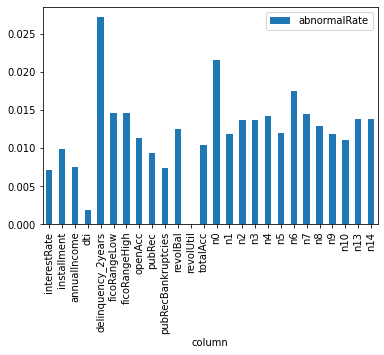

In [ ]:
tmpPd = pd.DataFrame({
    "column": feaList, 
    "abnormalRate": numList,
})
tmpPd.set_index(["column"], inplace=True)
tmpPd.plot(kind='bar')

In [ ]:
import numpy as np
from scipy.stats import chi
import pandas as pd
from pandas import DataFrame,Series
import scipy

def chi3(arr):
    '''
    计算卡方值
    arr:频数统计表,二维numpy数组。
    '''
    assert(arr.ndim==2)
    #计算每行总频数
    R_N = arr.sum(axis=1)
    #每列总频数
    C_N = arr.sum(axis=0)
    #总频数
    N = arr.sum()
    # 计算期望频数 C_i * R_j / N。
    E = np.ones(arr.shape)* C_N / N
    E = (E.T * R_N).T
    square = (arr-E)**2 / E
    #期望频数为0时，做除数没有意义，不计入卡方值
    square[E==0] = 0
    #卡方值
    v = square.sum()
    return v

def chiMerge(df,col,target,max_groups=None,threshold=None):

    '''
    卡方分箱
    df: pandas dataframe数据集
    col: 需要分箱的变量名（数值型）
    target: 类标签
    max_groups: 最大分组数。
    threshold: 卡方阈值，如果未指定max_groups，默认使用置信度95%设置threshold。
    return: 包括各组的起始值的列表.
    '''

    freq_tab = pd.crosstab(df[col],df[target])

    #转成numpy数组用于计算。
    freq = freq_tab.values

    #初始分组切分点，每个变量值都是切分点。每组中只包含一个变量值.

    #分组区间是左闭右开的，如cutoffs = [1,2,3]，则表示区间 [1,2) , [2,3) ,[3,3+)。
    cutoffs = freq_tab.index.values

    #如果没有指定最大分组
    if max_groups is None:    
        #如果没有指定卡方阈值，就以95%的置信度（自由度为类数目-1）设定阈值。
        if threshold is None:
            #类数目
            cls_num = freq.shape[-1]
            threshold = chi2.isf(0.05,df= cls_num - 1)

    while True:
        minvalue = None
        minidx = None
        #从第1组开始，依次取两组计算卡方值，并判断是否小于当前最小的卡方
        for i in range(len(freq) - 1):
            v = chi3(freq[i:i+2])
            if minvalue is None or (minvalue > v): #小于当前最小卡方，更新最小值
                minvalue = v
                minidx = i

        #如果最小卡方值小于阈值，则合并最小卡方值的相邻两组，并继续循环
        if  (max_groups is not None and  max_groups< len(freq) ) or (threshold is not None and minvalue < threshold):
            #minidx后一行合并到minidx
            tmp  = freq[minidx] + freq[minidx+1]
            freq[minidx] = tmp
            #删除minidx后一行
            freq = np.delete(freq,minidx+1,0)
            #删除对应的切分点
            cutoffs = np.delete(cutoffs,minidx+1,0)

        else: #最小卡方值不小于阈值，停止合并。
            break
    return cutoffs

def value2group(x,cutoffs):

    '''
    将变量的值转换成相应的组。
    x: 需要转换到分组的值
    cutoffs: 各组的起始值。
    return: x对应的组，如group1。从group1开始。
    '''

    #切分点从小到大排序。
    cutoffs = sorted(cutoffs)
    num_groups = len(cutoffs)

    #异常情况：小于第一组的起始值。这里直接放到第一组。
    #异常值建议在分组之前先处理妥善。
    if x < cutoffs[0]:
        return 1 #'group1'

    for i in range(1,num_groups):
        if cutoffs[i-1] <= x < cutoffs[i]:
            return i # 'group{}'.format(i)

    #最后一组，也可能会包括一些非常大的异常值。
    return num_groups #'group{}'.format(num_groups)

def calWOE(df ,var ,target):

    '''
    计算WOE编码
    param df：数据集pandas.dataframe
    param var：已分组的列名，无缺失值
    param target：响应变量（0,1）
    return：编码字典
    '''
    eps = 0.000001  #避免除以0
    gbi = pd.crosstab(df[var],df[target]) + eps
    gb = df[target].value_counts() + eps
    gbri = gbi/gb
    gbri['woe'] = np.log(gbri[1]/gbri[0])
    return gbri['woe'].to_dict()

def calIV(df,var,target):

    '''
    计算IV值
    param df：数据集pandas.dataframe
    param var：已分组的列名，无缺失值
    param target：响应变量（0,1）
    return：IV值
    '''
    eps = 0.000001  #避免除以0
    gbi = pd.crosstab(df[var],df[target]) + eps
    gb = df[target].value_counts() + eps
    gbri = gbi/gb
    gbri['woe'] = np.log(gbri[1]/gbri[0])
    gbri['iv'] = (gbri[1] - gbri[0])*gbri['woe']
    return gbri['iv'].sum()

### Scheme A

See abnormal values. Bin the columns that having many abnormal values. 我们仅查看异常值率大于0.015的。

`delinquency_2years, n0, n6` having abnormal values more than 1.5\%. 

In [ ]:
for fea in ["n0", "n6", "delinquency_2years"]:
    print("for feature: {}...".format(fea))
    cutoffs = chiMerge(data_train, fea,'isDefault',max_groups=10)
    data_train[fea] = data_train[fea].apply(value2group,args=(cutoffs,))
    data_test_a[fea] = data_test_a[fea].apply(value2group,args=(cutoffs,))

for feature: n0...
for feature: n6...
for feature: delinquency_2years...


### Scheme B

对全部的有异常值的列进行分箱

In [ ]:
for fea in [
            'interestRate',
            #'installment', #
            #'annualIncome',#
            #'dti', #
            'delinquency_2years',
            'ficoRangeLow',
            'ficoRangeHigh',
            'openAcc',
            'pubRec',
            'pubRecBankruptcies',
            #'revolBal', #
            'revolUtil',
            'totalAcc',
            'n0',
            'n1',
            'n2',
            'n3',
            'n4',
            'n5',
            'n6',
            'n7',
            'n8',
            'n9',
            'n10',
            'n13',
            'n14'
            ]:
    print("for feature: {}...".format(fea))
    cutoffs = chiMerge(data_train, fea,'isDefault',max_groups=10)
    data_train[fea] = data_train[fea].apply(value2group,args=(cutoffs,))
    data_test_a[fea] = data_test_a[fea].apply(value2group,args=(cutoffs,))

for feature: interestRate...
for feature: delinquency_2years...
for feature: ficoRangeLow...
for feature: ficoRangeHigh...
for feature: openAcc...
for feature: pubRec...
for feature: pubRecBankruptcies...
for feature: revolUtil...
for feature: totalAcc...
for feature: n0...
for feature: n1...
for feature: n2...
for feature: n3...
for feature: n4...
for feature: n5...
for feature: n6...
for feature: n7...
for feature: n8...
for feature: n9...
for feature: n10...
for feature: n13...
for feature: n14...


## Change `numerical_category_fewValues` 


### Scheme A

numerical_category_fewValues 被dummy了。

In [8]:
data_train = pd.get_dummies(data_train, columns=category_fea, drop_first=True)
data_test_a = pd.get_dummies(data_test_a, columns=category_fea, drop_first=True)

In [9]:
columnsThatTrainHasButTestDont = list(set(data_train.columns) - set(data_test_a.columns))
columnsThatTestHasButTrainDont = list(set(data_test_a.columns) - set(data_train.columns))
data_train[columnsThatTestHasButTrainDont] = 0
data_test_a[columnsThatTrainHasButTestDont] = 0

In [10]:
data_test_a.shape

(80000, 332)

In [11]:
data_train.shape

(200000, 332)

### Scheme B

不使用 dummy

In [ ]:
## Nothing is done. 

## Change `numerical_category_manyValues` 


###  Scheme A

不做处理

In [ ]:
## Nothing is done

## Feature Generation

利用 https://zhuanlan.zhihu.com/p/26444240 介绍的方法开展特征合成：

```
median(N1)_by(C1)  \\ 中位数
mean(N1)_by(C1)  \\ 算术平均数
mode(N1)_by(C1)  \\ 众数
min(N1)_by(C1)  \\ 最小值
max(N1)_by(C1)  \\ 最大值
std(N1)_by(C1)  \\ 标准差
var(N1)_by(C1)  \\ 方差
freq(C2)_by(C1)  \\ 频数

freq(C1) \\这个不需要groupby也有意义
```

In [ ]:
# data_train.to_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_x_x.csv", index=False)
# data_test_a.to_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_x_x.csv", index=False)

In [ ]:
# data_train = pd.read_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_x_x.csv")
# data_test_a = pd.read_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_x_x.csv")

In [ ]:
# ####
# ## 这个适用于A-F。
# ##
# ####

# from sklearn.feature_selection import SelectKBest
# from scipy.stats import pearsonr
# #选择K个最好的特征，返回选择特征后的数据
# #第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
# #输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
# #参数k为选择的特征个数

# def selectNFeatures(numSelectedFeatures, data_train, y_train, fillMethod = "ffill"):
#     ## 到时候，就指着返回下面两个表了
#     selectedFeatures = []
#     deletedFeatures = []

#     ## 无脑处理：将所有的正负无穷都处理掉。
#     data_train = data_train.replace([np.inf, -np.inf], np.nan)
#     ## 填充方法
#     if fillMethod in ["ffill", "bfill"]:
#         data_train = data_train.fillna(axis = 1, method = fillMethod) # "ffill"
#     else: 
#         data_train = data_train.fillna(data_train.median())  

#     ## columnsThatHaveNullVal 这些列，终究是有空值的，那就放弃他们吧。
#     tmpList = data_train.isnull().sum().to_frame('nulls')
#     columnsThatHaveNullVal = list(tmpList[tmpList["nulls"] > 0].index)
#     deletedFeatures.extend(columnsThatHaveNullVal)
#     data_train.drop(columnsThatHaveNullVal, axis = 1, inplace=True)

#     # print(data_train.isnull().sum())
#     # print()
#     # print(y_train.isnull().sum())
#     # print(data_train.head(20))
#     # print(np.any(np.isnan(data_train)))

#     selector = SelectKBest(k=numSelectedFeatures)
#     selector.fit(data_train, y_train)
#     colNums = selector.get_support(True)
#     # print(colNums)
#     for i, col in enumerate(list(data_train.columns)):
#         if i in colNums:
#             selectedFeatures.append(col)
#         # else: 
#         #     deletedFeatures.append(col)
#     # print(selectedFeatures, deletedFeatures)
            
#     return selectedFeatures , deletedFeatures

# def combinationOfFeatures(category, serial, method, method_name, data_train, data_test_a, n):
#     '''
#     combine and generate some new features. 

#     category: list of the categorical column names
#     serial: list of the serial column names
#     method: ["mean"], ["max"], ["min"], pd.Series.model, etc..
#     method_name: the name of the method. Must be strings. 
#     n: newly generated features, select n from them. if n == -1, then select all of the newly generated features. 
#     '''
#     # ori_cols_train = list(data_train.columns)
#     # ori_cols_test = list(data_test_a.columns)

#     new_cols = []
    
#     for col in category: 
#         for numFea in serial: #half_serials + ["isDefault"]: # for numFea in ["isDefault"]: 
#             # print("categorical: {}, serial: {}".format(col, numFea))
#             temp_dict = data_train.groupby([col])[numFea].agg(method).reset_index().rename(columns={method_name: col + '_{}_{}'.format(numFea, method_name)})
#             temp_dict.index = temp_dict[col].values
#             temp_dict = temp_dict[col + '_{}_{}'.format(numFea, method_name)].to_dict()
            
#             data_train[col + '_{}_{}'.format(numFea, method_name)] = data_train[col].map(temp_dict)
#             data_test_a[col + '_{}_{}'.format(numFea, method_name)] = data_test_a[col].map(temp_dict)
            
#             new_cols.append(col + '_{}_{}'.format(numFea, method_name))
    
#     if n >= 0: 
#         tmp_train = data_train[new_cols].copy()

#         selectedFeatures, deletedFeatures = selectNFeatures(n, tmp_train, data_train[["isDefault"]]) #

#         data_train.drop(deletedFeatures, axis = 1, inplace=True)
#         data_test_a.drop(deletedFeatures, axis = 1, inplace=True)
#         # data_train = data_train[ori_cols_train + selectedFeatures]
#         # data_test_a = data_test_a[ori_cols_test + selectedFeatures]

#     elif n < 0:
#         pass

#     return data_train, data_test_a

# def combinationOfFeatures_divide(feaGroup1, feaGroup2, method, df, df_test, n):
#     ori_cols_train = list(df.columns)
#     ori_cols_test = list(df_test.columns)

#     new_cols = []

#     for fea1 in feaGroup1: ## grade
#         for fea2 in feaGroup2: ## nXX
            
#             df['{}_to_{}_'.format(fea1, method) + fea2] = df[fea1] / df.groupby([fea2])[fea1].transform(method)
#             df_test['{}_to_{}_'.format(fea1, method) + fea2] = df_test[fea1] / df_test.groupby([fea2])[fea1].transform(method)
            
#             new_cols.append('{}_to_{}_'.format(fea1, method) + fea2)
#     # print(new_cols)
    
#     if n >= 0:
#         tmp_train = df[new_cols].copy()
        
#         selectedFeatures , deletedFeatures = selectNFeatures(n, tmp_train, df[["isDefault"]], "median") # 
#         # print(data_train.columns)
#         # print(data_train.)
#         # print(selectedFeatures)
        
#         df.drop(deletedFeatures, axis = 1, inplace=True)
#         df_test.drop(deletedFeatures, axis = 1, inplace=True)
#         # df = df[ori_cols_train + selectedFeatures]
#         # df_test = df_test[ori_cols_test + selectedFeatures]
    
#     elif n < 0:
#         pass

#     return df, df_test

In [29]:
####
## 这个适用于F2及以后。
##
####
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
#输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数

def selectNFeatures(numSelectedFeatures, data_train, y_train, fillMethod = "ffill"):
    ## 到时候，就指着返回下面两个表了
    selectedFeatures = []
    # deletedFeatures = []

    ## 无脑处理：将所有的正负无穷都处理掉。
    data_train = data_train.replace([np.inf, -np.inf], np.nan)
    ## 填充方法
    if fillMethod in ["ffill", "bfill"]:
        data_train = data_train.fillna(axis = 1, method = fillMethod) # "ffill"
    else: 
        data_train = data_train.fillna(data_train.median())  

    ## columnsThatHaveNullVal 这些列，终究是有空值的，那就放弃他们吧。
    tmpList = data_train.isnull().sum().to_frame('nulls')
    columnsThatHaveNullVal = list(tmpList[tmpList["nulls"] > 0].index)
    # deletedFeatures.extend(columnsThatHaveNullVal)
    data_train.drop(columnsThatHaveNullVal, axis = 1, inplace=True)

    # print(data_train.isnull().sum())
    # print()
    # print(y_train.isnull().sum())
    # print(data_train.head(20))
    # print(np.any(np.isnan(data_train)))

    selector = SelectKBest(k=numSelectedFeatures)
    selector.fit(data_train, y_train)
    colNums = selector.get_support(True)
    # print(colNums)
    for i, col in enumerate(list(data_train.columns)):
        if i in colNums:
            selectedFeatures.append(col)
        # else: 
        #     deletedFeatures.append(col)
    # print(selectedFeatures, deletedFeatures)
            
    return selectedFeatures #, deletedFeatures

def combinationOfFeatures(category, serial, method, method_name, data_train, data_test_a, n):
    '''
    combine and generate some new features. 

    category: list of the categorical column names
    serial: list of the serial column names
    method: ["mean"], ["max"], ["min"], pd.Series.model, etc..
    method_name: the name of the method. Must be strings. 
    n: newly generated features, select n from them. if n == -1, then select all of the newly generated features. 
    '''
    ori_cols_train = list(data_train.columns)
    ori_cols_test = list(data_test_a.columns)

    new_cols = []
    
    for col in category: 
        for numFea in serial: #half_serials + ["isDefault"]: # for numFea in ["isDefault"]: 
            # print("categorical: {}, serial: {}".format(col, numFea))
            temp_dict = data_train.groupby([col])[numFea].agg(method).reset_index().rename(columns={method_name: col + '_{}_{}'.format(numFea, method_name)})
            temp_dict.index = temp_dict[col].values
            temp_dict = temp_dict[col + '_{}_{}'.format(numFea, method_name)].to_dict()
            
            data_train[col + '_{}_{}'.format(numFea, method_name)] = data_train[col].map(temp_dict)
            data_test_a[col + '_{}_{}'.format(numFea, method_name)] = data_test_a[col].map(temp_dict)
            
            new_cols.append(col + '_{}_{}'.format(numFea, method_name))
    
    if n >= 0: 
        tmp_train = data_train[new_cols].copy()

        selectedFeatures = selectNFeatures(n, tmp_train, data_train[["Evaluation"]]) #, deletedFeatures

        # data_train.drop(deletedFeatures, axis = 1, inplace=True)
        # data_test_a.drop(deletedFeatures, axis = 1, inplace=True)
        data_train = data_train[ori_cols_train + selectedFeatures]
        data_test_a = data_test_a[ori_cols_test + selectedFeatures]

    elif n < 0:
        pass

    return data_train, data_test_a

def combinationOfFeatures_divide(feaGroup1, feaGroup2, method, df, df_test, n):
    ori_cols_train = list(df.columns)
    ori_cols_test = list(df_test.columns)

    new_cols = []

    for fea1 in feaGroup1: ## grade
        for fea2 in feaGroup2: ## nXX
            
            df['{}_to_{}_'.format(fea1, method) + fea2] = df[fea1] / df.groupby([fea2])[fea1].transform(method)
            df_test['{}_to_{}_'.format(fea1, method) + fea2] = df_test[fea1] / df_test.groupby([fea2])[fea1].transform(method)
            
            new_cols.append('{}_to_{}_'.format(fea1, method) + fea2)
    # print(new_cols)
    
    if n >= 0:
        tmp_train = df[new_cols].copy()
        
        selectedFeatures = selectNFeatures(n, tmp_train, df[["Evaluation"]], "median") # , deletedFeatures
        # print(data_train.columns)
        # print(data_train.)
        # print(selectedFeatures)
        
        # df.drop(deletedFeatures, axis = 1, inplace=True)
        # df_test.drop(deletedFeatures, axis = 1, inplace=True)
        df = df[ori_cols_train + selectedFeatures]
        df_test = df_test[ori_cols_test + selectedFeatures]
    
    elif n < 0:
        pass

    return df, df_test

### Scheme A: 

那我们着重应对的就是`numerical_category_manyValues, date_type`和`object_serial, numerical_serial`可以组合处理一下。

怎么做呢？根据C1列的取值对N1列进行分组。比如C1能取1，2，3三个值，然后根据这三个值把N1进行分组。然后获得1对应的N1分组的平均值、平均值、众数、中位数、最大值、最小值、标准差、方差、频数，然后用获得的这些值创建新的列。

取5个值？

In [18]:
data_train.shape

(200000, 38)

In [19]:
data_train.head()

,CaseId,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Evaluation
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0
2,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2,3,1,0,0,1,1,0
4,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2,4,1,0,0,1,1,0


In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["mean"], 
    "mean", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
## 失败，这种方法目测是用不了的。
# data_train, data_test_a = combinationOfFeatures(
#     numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
#     object_serial + numerical_serial + ["isDefault"],
#     pd.Series.mode,
#     "mode",
#     data_train, 
#     data_test_a, 
#     5
# )

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["max"], 
    "max", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["min"], 
    "min", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["std"], 
    "std", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["var"], 
    "var", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial + ["isDefault"],
    ["count"],
    "count",  
    data_train, 
    data_test_a, 
    5
)

In [ ]:
# for col in numerical_category_manyValues: 
#     for numFea in ["isDefault"]: #half_serials + ["isDefault"]: # for numFea in object_serial + numerical_serial + ["isDefault"]:
#         temp_dict = data_train.groupby([col])[numFea].agg(['mean']).reset_index().rename(columns={'mean': col + '_{}_mean'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         # print(temp_dict.head())
#         temp_dict = temp_dict[col + '_{}_mean'.format(numFea)].to_dict()
#         # print(col, " ", temp_dict, sum(temp_dict.values()), "\n")
#         data_train[col + '_{}_mean'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_mean'.format(numFea)] = data_test_a[col].map(temp_dict)
# data_train.head()

In [ ]:
# for col in numerical_category_manyValues: 
#     for numFea in ["isDefault"]: #object_serial + numerical_serial:
#         temp_dict = data_train.groupby([col])[numFea].agg(['max']).reset_index().rename(columns={'max': col + '_{}_max'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         # print(temp_dict.head())
#         temp_dict = temp_dict[col + '_{}_max'.format(numFea)].to_dict()
#         # print(col, " ", temp_dict, sum(temp_dict.values()), "\n")
#         data_train[col + '_{}_max'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_max'.format(numFea)] = data_test_a[col].map(temp_dict)
# data_train.head()

In [ ]:
# for col in numerical_category_manyValues: 
#     for numFea in ["isDefault"]: #object_serial + numerical_serial:
#         temp_dict = data_train.groupby([col])[numFea].agg(['min']).reset_index().rename(columns={'min': col + '_{}_min'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         # print(temp_dict.head())
#         temp_dict = temp_dict[col + '_{}_min'.format(numFea)].to_dict()
#         # print(col, " ", temp_dict, sum(temp_dict.values()), "\n")
#         data_train[col + '_{}_min'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_min'.format(numFea)] = data_test_a[col].map(temp_dict)
# data_train.head()

In [ ]:
# for col in numerical_category_manyValues: 
#     for numFea in ["isDefault"]: #half_serials + ["isDefault"]: # for numFea in object_serial + numerical_serial:
#         temp_dict = data_train.groupby([col])[numFea].agg(['std']).reset_index().rename(columns={'std': col + '_{}_std'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         # print(temp_dict.head())
#         temp_dict = temp_dict[col + '_{}_std'.format(numFea)].to_dict()
#         # print(col, " ", temp_dict, sum(temp_dict.values()), "\n")
#         data_train[col + '_{}_std'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_std'.format(numFea)] = data_test_a[col].map(temp_dict)
# data_train.head()

In [ ]:
data_train.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'annualIncome',
       'issueDate', 'isDefault', 'purpose', 'postCode', 'regionCode', 'dti',
       'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc',
       'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'earliesCreditLine', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n3',
       'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14', 'issueYear',
       'issueMonth', 'earliesCreditLineYear', 'earliesCreditLineMonth',
       'issueDateDT', 'earliesCreditLineDT', 'homeOwnership_1',
       'homeOwnership_2', 'homeOwnership_3', 'homeOwnership_4',
       'homeOwnership_5', 'verificationStatus_1', 'verificationStatus_2',
       'initialListStatus_1', 'applicationType_1', 'n11_1.0', 'n11_2.0',
       'n11_3.0', 'n11_4.0', 'n12_1.0', 'n12_2.0', 'n12_3.0', 'n12_4.0',
       'employmentTitle_grade_median', 'employmentTitle

### Scheme B: 

跟A大体一样，就是新增几个列，少取几个值。

取5个值？

In [ ]:
data_train.shape

(800000, 53)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["mean"], 
    "mean", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
## 失败，这种方法目测是用不了的。
# data_train, data_test_a = combinationOfFeatures(
#     numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
#     object_serial + numerical_serial + ["isDefault"],
#     pd.Series.mode,
#     "mode",
#     data_train, 
#     data_test_a, 
#     5
# )

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["max"], 
    "max", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["min"], 
    "min", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["std"], 
    "std", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["var"], 
    "var", 
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    object_serial + numerical_serial + ["isDefault"],
    ["count"],
    "count",  
    data_train, 
    data_test_a, 
    3
)

In [ ]:
data_train.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'issueYear', 'issueMonth',
       'earliesCreditLineYear', 'earliesCreditLineMonth', 'issueDateDT',
       'earliesCreditLineDT', 'employmentTitle_subGrade_median',
       'employmentTitle_isDefault_median', 'title_isDefault_median',
       'employmentTitle_subGrade_mean', 'employmentTitle_isDefault_mean',
       'title_isDefault_mean', 'employmentTitle_isDefault_max',
       't

### Scheme C

传统的方法

In [ ]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [ ]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

### Scheme D

在C方案的基础上，增加一点点特征，不要多，就5个。

In [ ]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [ ]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial, # + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train.shape

### Scheme E

在D的基础上，做了一些适应于（`numerical_category_fewValues`被dummy）后的改变。

In [ ]:
numerical_category_fewValues

['homeOwnership',
 'verificationStatus',
 'initialListStatus',
 'applicationType',
 'n11',
 'n12']

In [ ]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [ ]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n13','n14']: # 'n11','n12',
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial, # + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train.shape

(800000, 97)

### Scheme F

还没写完呢，别着急

先来两波这个啥？我也说不上来。

In [ ]:
data_train, data_test_a = combinationOfFeatures_divide(
    object_serial, #["grade", "subGrade"], 
    ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
    "std", 
    data_train,
    data_test_a, 
    10,
)

In [ ]:
data_train, data_test_a = combinationOfFeatures_divide(
    object_serial, #["grade", "subGrade", ""], 
    ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
    "mean", 
    data_train,
    data_test_a, 
    10,
)

In [ ]:
data_train.shape

(800000, 73)

再来一大波这些东西，我更是说不上来了。

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["mean"], 
    "mean", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["max"], 
    "max", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["min"], 
    "min", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["std"], 
    "std", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["var"], 
    "var", 
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["count"],
    "count",  
    data_train, 
    data_test_a, 
    2
)

In [ ]:
data_train.shape

(800000, 87)

### Scheme F1

在F的基础上再做一点调整。

先来两波这个啥？我也说不上来。

In [ ]:
data_train, data_test_a = combinationOfFeatures_divide(
    object_serial, #["grade", "subGrade"], 
    ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
    "std", 
    data_train,
    data_test_a, 
    10,
)

In [ ]:
data_train, data_test_a = combinationOfFeatures_divide(
    object_serial, #["grade", "subGrade", ""], 
    ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
    "mean", 
    data_train,
    data_test_a, 
    10,
)

In [ ]:
data_train.shape

(800000, 73)

再来一大波这些东西，我更是说不上来了。

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    5
)
data_train.shape

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["mean"], 
    "mean", 
    data_train, 
    data_test_a, 
    5
)
data_train.shape

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["max"], 
    "max", 
    data_train, 
    data_test_a, 
    5
)
data_train.shape

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["min"], 
    "min", 
    data_train, 
    data_test_a, 
    5
)
data_train.shape

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["std"], 
    "std", 
    data_train, 
    data_test_a, 
    5
)
data_train.shape

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["var"], 
    "var", 
    data_train, 
    data_test_a, 
    5
)
data_train.shape

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    numerical_category_fewValues + numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'], 
    object_serial + numerical_serial,# + ["isDefault"],
    ["count"],
    "count",  
    data_train, 
    data_test_a, 
    5
)
data_train.shape

In [ ]:
data_train.shape

(800000, 108)

### Scheme F2

在F的基础上再做一点调整。

再来一大波这些东西，我更是说不上来了。

In [20]:
data_train.head()

,CaseId,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Evaluation
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0
2,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2,3,1,0,0,1,1,0
4,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2,4,1,0,0,1,1,0


In [ ]:
numerical_noserial_fea

['Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q5',
 'Q6',
 'Q7',
 'Q8',
 'Q9',
 'Q10',
 'Q11',
 'Q12',
 'Q13',
 'Q14',
 'Q15',
 'Q16',
 'Q17',
 'Q18',
 'Q19',
 'Q20',
 'Q21',
 'Q22',
 'Q23',
 'Q26',
 'Q28',
 'Q30',
 'Q32',
 'Q34',
 'Q35',
 'Q36']

In [ ]:
numerical_serial_fea

['Q24', 'Q25', 'Q27', 'Q29', 'Q31', 'Q33']

In [38]:
data_train, data_test_a = combinationOfFeatures(
    numerical_noserial_fea, 
    numerical_serial_fea, 
    ["median"], 
    "median", 
    data_train, 
    data_test_a, 
    10
)
data_train.shape

(200000, 48)

In [39]:
data_train, data_test_a = combinationOfFeatures(
    numerical_noserial_fea, 
    numerical_serial_fea, 
    ["mean"], 
    "mean", 
    data_train, 
    data_test_a, 
    10
)
data_train.shape

(200000, 58)

In [40]:
data_train, data_test_a = combinationOfFeatures(
    numerical_noserial_fea, 
    numerical_serial_fea, 
    ["max"], 
    "max", 
    data_train, 
    data_test_a, 
    10
)
data_train.shape

(200000, 68)

In [41]:
data_train, data_test_a = combinationOfFeatures(
    numerical_noserial_fea, 
    numerical_serial_fea, 
    ["min"], 
    "min", 
    data_train, 
    data_test_a, 
    10
)
data_train.shape

(200000, 78)

In [42]:
data_train, data_test_a = combinationOfFeatures(
    numerical_noserial_fea, 
    numerical_serial_fea, 
    ["std"], 
    "std", 
    data_train, 
    data_test_a, 
    10
)
data_train.shape

(200000, 88)

In [43]:
data_train, data_test_a = combinationOfFeatures(
    numerical_noserial_fea, 
    numerical_serial_fea, 
    ["var"], 
    "var", 
    data_train, 
    data_test_a, 
    5
)
data_train.shape

(200000, 93)

In [45]:
data_train, data_test_a = combinationOfFeatures(
    numerical_noserial_fea, 
    numerical_serial_fea, 
    ["count"],
    "count",  
    data_train, 
    data_test_a, 
    10
)
data_train.shape

(200000, 103)

In [ ]:
# data_train.to_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_f1_x.csv", index=False)
# data_test_a.to_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_f1_x.csv", index=False)

上面这一波操作，已经做过，可以参考下列的中间结果。

In [ ]:
# data_train = pd.read_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_f1_x.csv")
# data_test_a = pd.read_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_f1_x.csv")
# data_train.shape

(800000, 93)

In [ ]:
# data_train, data_test_a = combinationOfFeatures_divide(
#     object_serial, numerical_serial
#     method, 
#     data_train,
#     data_test_a, 
#     10,
# )

In [ ]:
from itertools import combinations, permutations
hhd = map(lambda x: list(x), list(
    permutations(
        ["median", "mean", "max", "min", "std", "var", "count"],
        2
    )
))
list(hhd)

In [ ]:
# def generateDivideFeatures_combination1(data_train, data_test_a, features1, features2): 
#     ### 怎么计算最后新增的特征数量？
#     #### method的总数 * combinationOfFeatures_divide最后一个参数
#     # for fea in tqdm.tqdm_notebook(features1):
#     for method in tqdm.tqdm_notebook(['median', 'std'],): #"median", "mean", "max", "min", "std", "var", "count"
#         data_train, data_test_a = combinationOfFeatures_divide(
#             features1,
#             features2, 
#             method, 
#             data_train,
#             data_test_a, 
#             15,
#         )
#     return data_train, data_test_a

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination1(
#     data_train, data_test_a, 
#     object_serial, numerical_serial
# )
# data_train.shape

(800000, 153)

-----------------------------

先来几波这个啥？我也说不上来。

In [ ]:
# from itertools import combinations, permutations
# hhd = map(lambda x: list(x), list(
#     permutations(
#         ["median", "mean", "max", "min", "std", "var", "count"],
#         2
#     )
# ))
# list(hhd)

In [ ]:
# data_train = pd.read_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_x_x.csv")
# data_test_a = pd.read_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_x_x.csv")
# data_train.shape

In [ ]:
def generateDivideFeatures_combination(data_train, data_test_a, features1, features2): 
    ### 怎么计算最后新增的特征数量？
    #### len(feature1) * method的总数 * combinationOfFeatures_divide最后一个参数
    for fea in tqdm.tqdm_notebook(features1):
        for method in ['median', 'mean']: #"median", "mean", "max", "min", "std", "var", "count"
            data_train, data_test_a = combinationOfFeatures_divide(
                [fea], 
                features2, 
                method, 
                data_train,
                data_test_a, 
                10,
            )
    return data_train, data_test_a

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     object_serial, numerical_serial
# )
# data_train.shape

------------------------------------

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_category_fewValues, numerical_category_manyValues
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     ["homeOwnership", "verificationStatus", "initialListStatus", "n12"], 
#     [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ]
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_category_fewValues, numerical_serial
# )
# data_train.shape

In [ ]:
## 失败。
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     [ "applicationType", "n11", "n12"], # "verificationStatus","initialListStatus",
#     object_serial
# )
# data_train.shape

-------------------------

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_category_manyValues, numerical_category_fewValues
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_category_manyValues, [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ]
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_category_manyValues, numerical_serial
# )
# data_train.shape

In [ ]:
## 有错，暂时不弄
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_category_manyValues, object_serial
# )
# data_train.shape

---------------------------------

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ], numerical_category_fewValues
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ], numerical_category_manyValues
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ], numerical_serial
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ], object_serial
# )
# data_train.shape

---------------------------

In [ ]:
## 先不弄
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_serial, numerical_category_fewValues
# )
# data_train.shape

In [ ]:
## 先不弄
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_serial, numerical_category_manyValues
# )
# data_train.shape

In [ ]:
## 先不弄
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_serial, [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ]
# )
# data_train.shape

In [ ]:
## 先不弄
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     numerical_serial, object_serial
# )
# data_train.shape

------------------------

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     object_serial, numerical_category_fewValues
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     object_serial, numerical_category_manyValues
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     object_serial, [
#         "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#         "issueYear", "issueMonth"
#     ]
# )
# data_train.shape

In [ ]:
# data_train, data_test_a = generateDivideFeatures_combination(
#     data_train, data_test_a, 
#     object_serial, numerical_serial
# )
# data_train.shape

--------------

In [ ]:
## 先不弄
# data_train, data_test_a = combinationOfFeatures_divide(
#     object_serial, #["grade", "subGrade"], 
#     ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
#     "std", 
#     data_train,
#     data_test_a, 
#     10,
# )

In [ ]:
## 先不弄
# data_train, data_test_a = combinationOfFeatures_divide(
#     object_serial, #["grade", "subGrade", ""], 
#     ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
#     "mean", 
#     data_train,
#     data_test_a, 
#     10,
# )

In [ ]:
# data_train.shape

(800000, 73)

### Scheme G

使用库来做特征工程

In [ ]:
!pip install featuretools

https://github.com/scottlinlin/auto_feature_demo

In [73]:
data_train = pd.read_csv('originalDataset/train.csv')
data_test_a = pd.read_csv('originalDataset/test.csv')

In [52]:
import featuretools as ft

In [74]:
data_train.shape

(200000, 38)

In [77]:
data_train.head()

,CaseId,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Evaluation
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0
2,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2,3,1,0,0,1,1,0
4,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2,4,1,0,0,1,1,0


In [89]:
data_train_5cols = data_train[["CaseId"] + ["Q{}".format(i) for i in range(1, 6)]]
data_train_5cols

,CaseId,Q1,Q2,Q3,Q4,Q5
0,1,0,0,0,0,0
1,2,0,0,0,0,0
2,3,0,0,0,0,0
3,4,0,0,0,0,0
4,5,0,0,0,0,0
...,...,...,...,...,...,...
199995,199996,0,1,0,0,0
199996,199997,0,0,0,0,0
199997,199998,0,0,0,0,0
199998,199999,0,0,0,0,0


In [90]:
data_train_10cols = data_train[["CaseId"] + ["Q{}".format(i) for i in range(6, 16)]]
data_train_10cols

,CaseId,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15
0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,1,0,0,0,0
2,3,0,0,1,0,0,1,0,0,0,0
3,4,0,0,0,0,0,1,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
199995,199996,0,0,0,0,0,1,0,0,0,0
199996,199997,0,0,0,0,0,1,0,0,0,0
199997,199998,0,0,0,0,0,1,0,0,0,0
199998,199999,0,0,0,0,0,1,0,0,0,0


In [91]:
es = ft.EntitySet(id = 'record')
#添加clients实体
es5cols = es.entity_from_dataframe(entity_id = 'record5cols', 
                              dataframe = data_train_5cols, 
                              variable_types = {
                                  "Q{}".format(i): ft.variable_types.Categorical for i in range(1, 5) 
                              },
                              # make_index = True, 
                              index = 'CaseId')
es10cols = es.entity_from_dataframe(entity_id = 'record10cols', 
                              dataframe = data_train_10cols, 
                              variable_types = {
                                  "Q{}".format(i): ft.variable_types.Categorical for i in range(6, 16) 
                              },
                              # make_index = True, 
                              index = 'id')
es

Entityset: record
  Entities:
    record5cols [Rows: 200000, Columns: 6]
    record10cols [Rows: 200000, Columns: 12]
  Relationships:
    No relationships

In [92]:
#添加实体关系
# 通过client_id 关联clients和loans实体
r_client_previous = ft.Relationship(es['record5cols']['CaseId'],
                                    es['record10cols']['CaseId'])
es = es.add_relationship(r_client_previous)

#打印实体集
es

Entityset: record
  Entities:
    record5cols [Rows: 200000, Columns: 6]
    record10cols [Rows: 200000, Columns: 12]
  Relationships:
    record10cols.CaseId -> record5cols.CaseId

In [93]:
#聚合特征,并生成新特征
features, feature_names = ft.dfs(entityset = es, target_entity = 'record5cols')
features.head()

,Q5,Q1,Q2,Q3,Q4,COUNT(record10cols),MODE(record10cols.Q10),MODE(record10cols.Q11),MODE(record10cols.Q12),MODE(record10cols.Q13),MODE(record10cols.Q14),MODE(record10cols.Q15),MODE(record10cols.Q6),MODE(record10cols.Q7),MODE(record10cols.Q8),MODE(record10cols.Q9),NUM_UNIQUE(record10cols.Q10),NUM_UNIQUE(record10cols.Q11),NUM_UNIQUE(record10cols.Q12),NUM_UNIQUE(record10cols.Q13),NUM_UNIQUE(record10cols.Q14),NUM_UNIQUE(record10cols.Q15),NUM_UNIQUE(record10cols.Q6),NUM_UNIQUE(record10cols.Q7),NUM_UNIQUE(record10cols.Q8),NUM_UNIQUE(record10cols.Q9)
CaseId,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
5,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1


In [98]:
newFeatures = features.drop(["Q{}".format(i) for i in range(1, 5 + 1)], axis = 1)
newFeatures.head()

,COUNT(record10cols),MODE(record10cols.Q10),MODE(record10cols.Q11),MODE(record10cols.Q12),MODE(record10cols.Q13),MODE(record10cols.Q14),MODE(record10cols.Q15),MODE(record10cols.Q6),MODE(record10cols.Q7),MODE(record10cols.Q8),MODE(record10cols.Q9),NUM_UNIQUE(record10cols.Q10),NUM_UNIQUE(record10cols.Q11),NUM_UNIQUE(record10cols.Q12),NUM_UNIQUE(record10cols.Q13),NUM_UNIQUE(record10cols.Q14),NUM_UNIQUE(record10cols.Q15),NUM_UNIQUE(record10cols.Q6),NUM_UNIQUE(record10cols.Q7),NUM_UNIQUE(record10cols.Q8),NUM_UNIQUE(record10cols.Q9)
CaseId,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
2,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
3,1,0,1,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1
4,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
5,1,0,1,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1


In [105]:
newFeatures.reset_index(inplace=True)
newFeatures.drop(["CaseId"], axis = 1, inplace = True)
newFeatures

,COUNT(record10cols),MODE(record10cols.Q10),MODE(record10cols.Q11),MODE(record10cols.Q12),MODE(record10cols.Q13),MODE(record10cols.Q14),MODE(record10cols.Q15),MODE(record10cols.Q6),MODE(record10cols.Q7),MODE(record10cols.Q8),MODE(record10cols.Q9),NUM_UNIQUE(record10cols.Q10),NUM_UNIQUE(record10cols.Q11),NUM_UNIQUE(record10cols.Q12),NUM_UNIQUE(record10cols.Q13),NUM_UNIQUE(record10cols.Q14),NUM_UNIQUE(record10cols.Q15),NUM_UNIQUE(record10cols.Q6),NUM_UNIQUE(record10cols.Q7),NUM_UNIQUE(record10cols.Q8),NUM_UNIQUE(record10cols.Q9)
0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
1,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
2,1,0,1,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1
3,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
4,1,0,1,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
199996,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
199997,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
199998,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1


In [106]:
newData_train = pd.concat([data_train, newFeatures], axis = 1)
newData_train.shape

(200000, 59)

In [126]:
newData_train.shape

(200000, 59)

In [114]:
# import imblearn
from imblearn.over_sampling import SMOTE

In [130]:
features_ = [f for f in newData_train.columns if f not in ['Caseid', 'Evaluation', "policyCode", "issueDate", "earliesCreditLine"] and '_outliers' not in f]
y_train = newData_train['Evaluation']
x_train = newData_train[features_]
# x_test = data_test_a[features_]

In [131]:
x_train.head()

,CaseId,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,COUNT(record10cols),MODE(record10cols.Q10),MODE(record10cols.Q11),MODE(record10cols.Q12),MODE(record10cols.Q13),MODE(record10cols.Q14),MODE(record10cols.Q15),MODE(record10cols.Q6),MODE(record10cols.Q7),MODE(record10cols.Q8),MODE(record10cols.Q9),NUM_UNIQUE(record10cols.Q10),NUM_UNIQUE(record10cols.Q11),NUM_UNIQUE(record10cols.Q12),NUM_UNIQUE(record10cols.Q13),NUM_UNIQUE(record10cols.Q14),NUM_UNIQUE(record10cols.Q15),NUM_UNIQUE(record10cols.Q6),NUM_UNIQUE(record10cols.Q7),NUM_UNIQUE(record10cols.Q8),NUM_UNIQUE(record10cols.Q9)
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
2,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1
3,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2,3,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
4,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2,4,1,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1


In [118]:
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [135]:
list(newData_train.columns)

Index(['CaseId', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10',
       'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20',
       'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30',
       'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Evaluation',
       'COUNT(record10cols)', 'MODE(record10cols.Q10)',
       'MODE(record10cols.Q11)', 'MODE(record10cols.Q12)',
       'MODE(record10cols.Q13)', 'MODE(record10cols.Q14)',
       'MODE(record10cols.Q15)', 'MODE(record10cols.Q6)',
       'MODE(record10cols.Q7)', 'MODE(record10cols.Q8)',
       'MODE(record10cols.Q9)', 'NUM_UNIQUE(record10cols.Q10)',
       'NUM_UNIQUE(record10cols.Q11)', 'NUM_UNIQUE(record10cols.Q12)',
       'NUM_UNIQUE(record10cols.Q13)', 'NUM_UNIQUE(record10cols.Q14)',
       'NUM_UNIQUE(record10cols.Q15)', 'NUM_UNIQUE(record10cols.Q6)',
       'NUM_UNIQUE(record10cols.Q7)', 'NUM_UNIQUE(record10cols.Q8)',
       'NUM_UNIQUE(record10cols.Q9)'],
      dtype='object')

In [140]:
df = pd.DataFrame(data=x_train, columns=list(newData_train.columns).remove("Evaluation"))

In [141]:
df.shape

(200000, 58)

In [142]:
df.head()

,CaseId,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,COUNT(record10cols),MODE(record10cols.Q10),MODE(record10cols.Q11),MODE(record10cols.Q12),MODE(record10cols.Q13),MODE(record10cols.Q14),MODE(record10cols.Q15),MODE(record10cols.Q6),MODE(record10cols.Q7),MODE(record10cols.Q8),MODE(record10cols.Q9),NUM_UNIQUE(record10cols.Q10),NUM_UNIQUE(record10cols.Q11),NUM_UNIQUE(record10cols.Q12),NUM_UNIQUE(record10cols.Q13),NUM_UNIQUE(record10cols.Q14),NUM_UNIQUE(record10cols.Q15),NUM_UNIQUE(record10cols.Q6),NUM_UNIQUE(record10cols.Q7),NUM_UNIQUE(record10cols.Q8),NUM_UNIQUE(record10cols.Q9)
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
2,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1
3,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2,3,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
4,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2,4,1,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1


In [133]:
x_train.shape

(200000, 58)

In [134]:
y_train.shape

(200000,)

## Delete the features that will not be used to fit the model

No `xx_outliers` features, no labels, no original dates. 

In [ ]:
data_train.columns

Index(['CaseId', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10',
       'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20',
       'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30',
       'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Evaluation'],
      dtype='object')

### Scheme A

以后的scheme，可以考虑删掉一些被编码过的特征。但是这次，我们没删。

In [ ]:
# features = [f for f in data_train.columns if f not in ['id', 'isDefault', "policyCode", "issueDate", "earliesCreditLine"] and '_outliers' not in f]
# features.remove("n11_4.0")
# features.remove("n12_4.0")
# # data_train = data_train[(data_train["n11_4"] != 1) & (data_train["n12_4"] != 1)]
# y_train = data_train['isDefault']
# x_train = data_train[features]
# x_test = data_test_a[features]

### Scheme B

In [46]:
# features = [f for f in data_train.columns if f not in ['Caseid', 'Evaluation', "policyCode", "issueDate", "earliesCreditLine"] and '_outliers' not in f]
# y_train = data_train['Evaluation']
# x_train = data_train[features]
# x_test = data_test_a[features]

# Save preprocessed data if necessary

In [ ]:
# x_train.to_csv("preprocessedData/x_train-1129-A_A_A_B_B_A_F_B.csv", index=False)
# x_test.to_csv("preprocessedData/x_test-1129-A_A_A_B_B_A_F_B.csv", index=False)
# y_train.to_csv("preprocessedData/y_train-1129-A_A_A_B_B_A_F_B.csv", index=False)

# Load preprocessed data if applicable

In [ ]:
# x_train = pd.read_csv("preprocessedData/x_train-1129-A_A_A_B_B_A_F_B.csv")
# x_test = pd.read_csv("preprocessedData/x_test-1129-A_A_A_B_B_A_F_B.csv")
# y_train = pd.read_csv("preprocessedData/y_train-1129-A_A_A_B_B_A_F_B.csv")

# Some hands on model training

In [ ]:
## 这个方法能够
def changeTheParamStringToDict(string):
    params = string.replace("(", "").replace(")", "").split(", ")
    if "*" in params:
        params.remove("*")
    param_dict = {}
    for param in params:
        if "=" not in param: 
            param_name = param.strip()
            param_val = "NoDefaultValue"
        else: 
            param_name, param_val = param.split("=")
            param_val = param_val.replace("'", "")
            if param_val in ["True", "False"]:
                param_val = bool(param_val)
            elif param_val in ["None"]:
                param_val = None
            else:
                try: 
                    param_val = int(param_val)
                except:
                    try:
                        param_val = float(param_val)
                    except:
                        pass
        param_dict[param_name] = param_val
        
    return param_dict

# changeTheParamStringToDict("(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)")
lgb_str = "(params, train_set, num_boost_round=100, valid_sets=None, valid_names=None, fobj=None, feval=None, init_model=None, feature_name='auto', categorical_feature='auto', early_stopping_rounds=None, evals_result=None, verbose_eval=True, learning_rates=None, keep_training_booster=False, callbacks=None)"
changeTheParamStringToDict(lgb_str)

{'callbacks': None,
 'categorical_feature': 'auto',
 'early_stopping_rounds': None,
 'evals_result': None,
 'feature_name': 'auto',
 'feval': None,
 'fobj': None,
 'init_model': None,
 'keep_training_booster': True,
 'learning_rates': None,
 'num_boost_round': 100,
 'params': 'NoDefaultValue',
 'train_set': 'NoDefaultValue',
 'valid_names': None,
 'valid_sets': None,
 'verbose_eval': True}

### Scheme A

普通方案. 单个模型. 

In [119]:
def aucprFunction(pred, train_data):
    '''
    如果是给lgbm用的，参考https://github.com/microsoft/LightGBM/blob/c02917e493c36f3b1e349338f1087fed33126576/examples/python-guide/advanced_example.py#L154
    第一个返回值，是这个函数的可以说是名字或者是标记吧；score就是得到的分数；最后一个就是问，score是越高越好吗。
    '''
    labels = train_data.get_label()
    score = average_precision_score(labels, pred)
    return "AUC_PR", score, True

class AUCPR_forCAT(object):
    '''
    https://catboost.ai/docs/concepts/python-usages-examples.html#custom-loss-function-eval-metric
    '''
    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # approxes is a list of indexed containers
        # (containers with only __len__ and __getitem__ defined),
        # one container per approx dimension.
        # Each container contains floats.
        # weight is a one dimensional indexed container.
        # target is a one dimensional indexed container.
        
        # weight parameter can be None.
        # Returns pair (error, weights sum)

        ## weight没什么迪奥用。
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        approx = approxes[0]
        score = average_precision_score(list(target), approx)
        return score, -1
    
    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return error

def cv_model(clf, train_x, train_y, test_x, clf_name, folds = 5):
    # folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]

        if clf_name == "rf": 
            params = {
                'bootstrap': True,
                'ccp_alpha': 0.0,
                'class_weight': None,
                'criterion': 'gini',
                'max_depth': None,
                'max_features': 'auto',
                'max_leaf_nodes': None,
                'max_samples': None,
                'min_impurity_decrease': 0.0,
                'min_impurity_split': None,
                'min_samples_leaf': 1,
                'min_samples_split': 2,
                'min_weight_fraction_leaf': 0.0,
                'n_estimators': 100,
                'n_jobs': None,
                'oob_score': True,
                'random_state': 0,
                'verbose': 1,
                'warm_start': True
            }
            clf_example = clf(**params)# n_estimators=params["n_estimators"], random_state=params["random_state"] # n_estimators=100, random_state=0
            clf_example.fit(trn_x, trn_y)
            val_pred = clf_example.predict_proba(val_x)[:, 1]
            test_pred = clf_example.predict_proba(test_x)[:, 1]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt', 'objective': 'binary',
                # 'metric': 'auc',
                'min_child_weight': 5, 'num_leaves': 2 ** 5, 'lambda_l2': 10, 'feature_fraction': 0.8,
                'bagging_fraction': 0.8, 'bagging_freq': 4, 'learning_rate': 0.1, 'seed': 2020,
                'nthread': 28, 'n_jobs':24, 'silent': True, 'verbose': -1,    
                # 'device_type': 'gpu',
                # 'max_bin': 63
            }
            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200, feval=aucprFunction)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'gamma': 1,
                      'min_child_weight': 1.5, 'max_depth': 5, 'lambda': 10, 'subsample': 0.7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7,
                      'eta': 0.04, 'tree_method': "gpu_hist", #'exact', 
                      'seed': 2020, 'nthread': 36, "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            # https://stackoverflow.com/questions/55579610/xgboost-attributeerror-dataframe-object-has-no-attribute-feature-names
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            ## metrics函数：https://catboost.ai/docs/references/eval-metric__supported-metrics.html 
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False, "task_type": "GPU"} #, "eval_metric": "Kappa"
            
            model = clf(iterations=20000, **params)#, eval_metric = AUCPR_forCAT()
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        ## 下面这个test，可以考虑像如下这样进行，或者是求平均亦可。
        # test += test_pred / kf.n_splits ## Minke's invention, no basis or reference.
        test += test_pred
        ##
        train[valid_index] = val_pred
        cv_scores.append(average_precision_score(val_y, val_pred))
        
        print(sum(cv_scores)/len(cv_scores), cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    print("what is kf.n_splits?", kf.n_splits)
    return train, test / kf.n_splits

In [120]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")
    return cat_train, cat_test

def rf_model(x_train, y_train, x_test):
    rf_train, rf_test = cv_model(RandomForestClassifier, x_train, y_train, x_test, "rf")
    return rf_train, rf_test

In [143]:
xgb_train, xgb_test = xgb_model(df, y_train, x_test)

************************************ 1 ************************************
[0]	train-aucpr:0.723956	eval-aucpr:0.730992
Multiple eval metrics have been passed: 'eval-aucpr' will be used for early stopping.

Will train until eval-aucpr hasn't improved in 200 rounds.
[200]	train-aucpr:0.840266	eval-aucpr:0.849078
[400]	train-aucpr:0.852933	eval-aucpr:0.861448
[600]	train-aucpr:0.857547	eval-aucpr:0.865053
[800]	train-aucpr:0.860295	eval-aucpr:0.86617
[1000]	train-aucpr:0.862536	eval-aucpr:0.866867
[1200]	train-aucpr:0.864214	eval-aucpr:0.867046
[1400]	train-aucpr:0.865708	eval-aucpr:0.867145
[1600]	train-aucpr:0.867166	eval-aucpr:0.867058
Stopping. Best iteration:
[1422]	train-aucpr:0.865896	eval-aucpr:0.867178



ValueError: ignored

In [ ]:
lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

In [ ]:
## 这个方法很快啊，可以用这个方法粗略看一下效果
cat_train, cat_test = cat_model(x_train, y_train, x_test)

尝试一下用一个模型的x_train来训练一个逻辑回归模型

In [ ]:
from sklearn.linear_model import LogisticRegression

def stacking_logistic(clf, train_x, train_y, test_x, folds = 5):
    # folds = 5
    seed = 2020
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        # print(train_index)
        train_index = list(train_index)
        valid_index = list(valid_index)
        # print(train_index)
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x[train_index], train_y.iloc[train_index], train_x[valid_index], train_y.iloc[valid_index]
        trn_x = np.array(trn_x).reshape(-1, 1)
        val_x = np.array(val_x).reshape(-1, 1)
        print(trn_x.shape)
        ## logistic regression
        params = {
            "C": 1.0
        }
        model = clf(**params)
        model.fit(trn_x, trn_y)
        val_pred = model.predict(val_x)
        # test_pred = model.predict(test_x)
        print(average_precision_score(val_y, val_pred))

# LogisticRegression
# lg = LogisticRegression(C=1.0)  # 默认使用L2正则化避免过拟合，C=1.0表示正则力度(超参数，可以调参调优)
# lg.fit(voting_train, y_train_part)
# y_predict = lg.predict(x_test)

In [ ]:
stacking_logistic(LogisticRegression, cat_train, y_train, cat_test)

************************************ 1 ************************************
(160000, 1)
0.6062954652126228
************************************ 2 ************************************
(160000, 1)
0.613280048912191
************************************ 3 ************************************
(160000, 1)
0.6132065359743147
************************************ 4 ************************************
(160000, 1)
0.6129068809598155
************************************ 5 ************************************
(160000, 1)
0.6179696395978443


上面的结果，好烂。

保存训练的结果

In [ ]:
testA_result = pd.read_csv('originalDataset/sample_submit.csv')
testA_result_pred = testA_result.copy()

In [ ]:
testA_result_pred["Evaluation"] = rf_test
testA_result_pred.to_csv("submissionResults/1130-noProcess-rf-7604.csv", index=False) ## 

In [ ]:
testA_result_pred["Evaluation"] = xgb_test
testA_result_pred.to_csv("submissionResults/1130-noProcess-xgb-8583.csv", index=False) ## 

In [ ]:
testA_result_pred["Evaluation"] = xgb_test
testA_result_pred.to_csv("submissionResults/1130-noProcess-cat-8553.csv", index=False) ## 

In [ ]:
# testA_result_pred["isDefault"] = xgb_test

In [ ]:
# testA_result_pred.to_csv("submissionResults/1130-noProcess-cat-9653.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f1_b-xgb-7386.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-xgb-7385.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/xgboost-1128-A_A_A_B_A_A_E_A-7379.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/xgboost-1128-A_A_A_B_B_A_D_B-7383.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/xgboost-1128-A_A_A_B_B_A_C_B-????.csv", index=False) ## 理论上应该得分较高的。但是没训练完就给我停掉了。以后再试一次。

### Scheme B

多个模型的stacking

In [ ]:
## 使用A方案里面的函数. 

In [ ]:
## 如果有必要, 可以保存一轮. 
# testA_result_pred["isDefault"] = lgb_test
# testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb-7372.csv", index=False) ## 

In [ ]:
# cat_train, cat_test = cat_model(x_train, y_train, x_test)

In [ ]:
## 如果有必要, 可以保存一轮. 
# testA_result_pred["isDefault"] = cat_test
# testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-cat-????.csv", index=False) ## 

In [ ]:
# lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

三连

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
newStackingTrainingSet["lgb"] = lgb_train
newStackingTrainingSet["cat"] = cat_train
newStackingTrainingSet["xgb"] = xgb_train
# newStackingTrainingSet["rf"] = rf_train

newStackingTestSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
newStackingTestSet["lgb"] = lgb_test
newStackingTestSet["cat"] = cat_test
newStackingTestSet["xgb"] = xgb_test
# newStackingTestSet["rf"] = rf_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

In [ ]:
testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_cat_xgb+xgb-????.csv", index=False) ## 

In [ ]:
# newStackingTrainingSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
# newStackingTrainingSet["lgb"] = lgb_train
# newStackingTrainingSet["cat"] = cat_train
# newStackingTrainingSet["xgb"] = xgb_train
# newStackingTrainingSet.head()

In [ ]:
# newStackingTestSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
# newStackingTestSet["lgb"] = lgb_test
# newStackingTestSet["cat"] = cat_test
# newStackingTestSet["xgb"] = xgb_test
# newStackingTestSet.head()

In [ ]:
# xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

In [ ]:
# ## 如果有必要, 可以保存一轮. 
# testA_result_pred["isDefault"] = xgb_test_final
# testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_xgb_cat+xgb-????.csv", index=False) ## 

二连1

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["lgb", "cat"])
newStackingTrainingSet["lgb"] = lgb_train
newStackingTrainingSet["cat"] = cat_train
# newStackingTrainingSet["xgb"] = xgb_train

newStackingTestSet = pd.DataFrame(columns=["lgb", "cat"])
newStackingTestSet["lgb"] = lgb_test
newStackingTestSet["cat"] = cat_test
# newStackingTestSet["xgb"] = xgb_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_cat+xgb-????.csv", index=False) ## 

二连2

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["lgb", "xgb"])
newStackingTrainingSet["lgb"] = lgb_train
# newStackingTrainingSet["cat"] = cat_train
newStackingTrainingSet["xgb"] = xgb_train

newStackingTestSet = pd.DataFrame(columns=["lgb", "xgb"])
newStackingTestSet["lgb"] = lgb_test
# newStackingTestSet["cat"] = cat_test
newStackingTestSet["xgb"] = xgb_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_xgb+xgb-????.csv", index=False) ## 

二连3

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["cat", "xgb"])
# newStackingTrainingSet["lgb"] = lgb_train
newStackingTrainingSet["cat"] = cat_train
newStackingTrainingSet["xgb"] = xgb_train

newStackingTestSet = pd.DataFrame(columns=["cat", "xgb"])
# newStackingTestSet["lgb"] = lgb_test
newStackingTestSet["cat"] = cat_test
newStackingTestSet["xgb"] = xgb_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-cat_xgb+xgb-????.csv", index=False) ## 

### Scheme B1

重复三联

In [ ]:
xgb_train1, xgb_test1 = xgb_model(x_train, y_train, x_test)

In [ ]:
xgb_train2, xgb_test2 = xgb_model(x_train, y_train, x_test)

In [ ]:
xgb_train3, xgb_test3 = xgb_model(x_train, y_train, x_test)

### Scheme B2

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# def cv_model_voting(train_x, train_y, test_x, folds = 5):
#     # folds = 5
#     seed = 2020
#     kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

#     train = np.zeros(train_x.shape[0])
#     test = np.zeros(test_x.shape[0])

#     cv_scores = []

#     for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
#         print('************************************ {} ************************************'.format(str(i+1)))
#         trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]
#         #########################
#         params = {
#             'boosting_type': 'gbdt', 'objective': 'binary',
#             'metric': 'auc',
#             'min_child_weight': 5, 'num_leaves': 2 ** 5, 'lambda_l2': 10, 'feature_fraction': 0.8,
#             'bagging_fraction': 0.8, 'bagging_freq': 4, 'learning_rate': 0.1, 'seed': 2020,
#             'nthread': 28, 'n_jobs':24, 'silent': True, 'verbose': -1, "n_estimators": 100, "verbose": 1
#             # 'device_type': 'gpu',
#             # 'max_bin': 63
#         }
#         clf1 = lgb.LGBMClassifier(**params)
#         ############################
#         params = {'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'gamma': 1,
#                   'min_child_weight': 1.5, 'max_depth': 5, 'lambda': 10, 'subsample': 0.7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7,
#                   'eta': 0.04, 'tree_method': "gpu_hist", #'exact', 
#                   'seed': 2020, 'nthread': 36, "silent": True, "n_estimators": 100, "verbose": 1
#                   }
#         clf2 = xgb.XGBClassifier(**params)
#         ###########################################
#         ## metrics函数：https://catboost.ai/docs/references/eval-metric__supported-metrics.html 
#         params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
#                   'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False, "task_type": "GPU", "eval_metric": "AUC"} #, "eval_metric": "Kappa"
#         # clf3 = CatBoostRegressor(iterations=20000, **params)#, eval_metric = AUCPR_forCAT()
        
#         # vclf = VotingClassifier(estimators=[('lgb', clf1), ('xgb', clf2), ('cat', clf3)], voting='soft', weights=[1, 1.5, 1])
#         vclf = VotingClassifier(estimators=[('lgb', clf1), ('xgb', clf2)], voting='soft', weights=[1, 1.5])
#         vclf = vclf.fit(trn_x, trn_y)
#         val_pred = vclf.predict(val_x)
#         cv_scores.append(average_precision_score(val_y, val_pred))
#         print(sum(cv_scores)/len(cv_scores), cv_scores)

In [ ]:
# cv_model_voting(x_train, y_train, x_test)

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# def aucprFunction(pred, train_data):
#     '''
#     如果是给lgbm用的，参考https://github.com/microsoft/LightGBM/blob/c02917e493c36f3b1e349338f1087fed33126576/examples/python-guide/advanced_example.py#L154
#     第一个返回值，是这个函数的可以说是名字或者是标记吧；score就是得到的分数；最后一个就是问，score是越高越好吗。
#     '''
#     labels = train_data.get_label()
#     score = average_precision_score(labels, pred)
#     return "AUC_PR", score, True

# def softmax(x):
#     """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
#     return e_x / e_x.sum()

# def cv_model_voting1(train_x, train_y, test_x, folds = 5):
#     # folds = 5
#     seed = 2020
#     kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

#     train = np.zeros(train_x.shape[0])
#     test = np.zeros(test_x.shape[0])

#     cv_scores = []
#     # ["lgb", "xgb", "cat"]
#     weights = softmax([1, 1.2, 0.9])#
#     print(weights)

#     for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
#         print('************************************ {} ************************************'.format(str(i+1)))
#         trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]
#         val_pred = np.zeros(val_x.shape[0])
#         test_pred = np.zeros(test_x.shape[0])
#         for i, weight in enumerate(weights):
#             if i == 0: 
#                 #cat######################
#                 params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
#                           'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False, "task_type": "GPU", "eval_metric": "AUC"} #, "eval_metric": "Kappa"
                
#                 model = CatBoostRegressor(iterations=20000, **params, eval_metric = AUCPR_forCAT())#
#                 model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
#                           cat_features=[], use_best_model=True, verbose=500)
                
#                 val_pred += model.predict(val_x) * weight
#                 test_pred += model.predict(test_x) * weight
#             elif i == 1: 
#                 #xgb#########################
#                 train_matrix = xgb.DMatrix(trn_x , label=trn_y)
#                 valid_matrix = xgb.DMatrix(val_x , label=val_y)
                
#                 params = {'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'gamma': 1,
#                           'min_child_weight': 1.5, 'max_depth': 5, 'lambda': 10, 'subsample': 0.7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7,
#                           'eta': 0.04, 'tree_method': "gpu_hist", #'exact', 
#                           'seed': 2020, 'nthread': 36, "silent": True,
#                           }
                
#                 watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
                
#                 model = xgb.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
#                 val_pred  += model.predict(valid_matrix, ntree_limit=model.best_ntree_limit) * weight
#                 test_pred += model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit) * weight
#             else: 
#                 #lgb########################
#                 train_matrix = lgb.Dataset(trn_x, label=trn_y)
#                 valid_matrix = lgb.Dataset(val_x, label=val_y)

#                 params = {
#                     'boosting_type': 'gbdt', 'objective': 'binary',
#                     # 'metric': 'auc',
#                     'min_child_weight': 5, 'num_leaves': 2 ** 5, 'lambda_l2': 10, 'feature_fraction': 0.8,
#                     'bagging_fraction': 0.8, 'bagging_freq': 4, 'learning_rate': 0.1, 'seed': 2020,
#                     'nthread': 28, 'n_jobs':24, 'silent': True, 'verbose': -1,    
#                     # 'device_type': 'gpu',
#                     # 'max_bin': 63
#                 }
#                 model = lgb.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200, feval=aucprFunction)
#                 val_pred += model.predict(val_x, num_iteration=model.best_iteration) * weight
#                 test_pred += model.predict(test_x, num_iteration=model.best_iteration) * weight
#         cv_scores.append(average_precision_score(val_y, val_pred))
#         print(sum(cv_scores)/len(cv_scores), cv_scores)

In [ ]:
# cv_model_voting1(x_train, y_train, x_test)

### Scheme B3

使用了StratifiedKFold

怎么弄分类？首先, 先把pred改成分类结果. 然后把多个模型的分类结果跟label组合起来. 看有没有多数的判断. 如果有, 就拿多数的判断的pred值进行平均; 如果没有, 就任选一种情况来平均就好了.



In [ ]:
# x_train = pd.read_csv("preprocessedData/x_train-1129-A_A_A_B_B_A_F_B.csv")
# x_test = pd.read_csv("preprocessedData/x_test-1129-A_A_A_B_B_A_F_B.csv")
# y_train = pd.read_csv("preprocessedData/y_train-1129-A_A_A_B_B_A_F_B.csv")

In [ ]:
def generateSampleDataset(x_train, y_train, howManyLines = 10000):
    numFolds = len(x_train) // howManyLines
    skf = StratifiedKFold(n_splits=numFolds, random_state=2020, shuffle=True)
    for train_index, test_index in skf.split(x_train, y_train):
        val_x, val_y = x_train.iloc[test_index], y_train.iloc[test_index]
        return val_x, val_y

In [ ]:
## 取样一部分，默认10000行。 
x_train_part, y_train_part = generateSampleDataset(x_train, y_train, 1000)

In [ ]:
import random

def processRow(row):
    numOfCol = len(row)
    boundary = numOfCol//2
    actualSumOfLabel = sum(row[boundary:])
    maxSumOfLabel = boundary
    minSumOfLabel = 0
    avgSum = maxSumOfLabel / 2
    ### 
    if actualSumOfLabel < avgSum: ## boundary就是分类器的数量，actualsum就是多少个正类；
        targetLabel = 0
        divisor = boundary - actualSumOfLabel
    elif actualSumOfLabel == avgSum:
        targetLabel = random.choice([0, 1])
        divisor = avgSum #maxSumOfLabel // 2
    else:
        targetLabel = 1
        divisor = actualSumOfLabel
    ### 
    sumOfPred = 0
    for i in range(boundary, numOfCol):
        if row[i] == targetLabel: 
            sumOfPred += row[i - boundary]
    ### 
    return sumOfPred / divisor

def getVotedPred(df_origin):
    df = df_origin.copy()
    numOfCol = df.shape[1] ## 如果全都是1，那么最高也不过这个数
    for col in df.columns:
        df["class_{}".format(col)] = df[col] > 0.5
        df["class_{}".format(col)] = df["class_{}".format(col)].map({True: 1, False: 0})
    #############
    class_cols = list(filter(lambda x: "_" in x , list(df.columns)))
    df["avg"] = df.apply(processRow, axis = 1)  #df[class_cols].apply(lambda x)
    # list(df.columns)
    # df["final"] = df[]
    return df["avg"]

# heheda = changeToStackTable(newStackingTrainingSet)
# heheda.head(20)

In [ ]:
def aucprFunction(pred, train_data):
    '''
    如果是给lgbm用的，参考https://github.com/microsoft/LightGBM/blob/c02917e493c36f3b1e349338f1087fed33126576/examples/python-guide/advanced_example.py#L154
    第一个返回值，是这个函数的可以说是名字或者是标记吧；score就是得到的分数；最后一个就是问，score是越高越好吗。
    '''
    labels = train_data.get_label()
    score = average_precision_score(labels, pred)
    return "AUC_PR", score, True

class AUCPR_forCAT(object):
    '''
    https://catboost.ai/docs/concepts/python-usages-examples.html#custom-loss-function-eval-metric
    '''
    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # approxes is a list of indexed containers
        # (containers with only __len__ and __getitem__ defined),
        # one container per approx dimension.
        # Each container contains floats.
        # weight is a one dimensional indexed container.
        # target is a one dimensional indexed container.
        
        # weight parameter can be None.
        # Returns pair (error, weights sum)

        ## weight没什么迪奥用。
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        approx = approxes[0]
        score = average_precision_score(list(target), approx)
        return score, -1
    
    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return error

def cv_model_voting(train_x, train_y, test_x, folds = 5):
    # folds = 5
    seed = 2020
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]
        # if clf_name == "lgb":
        print("=================lgb================")
        train_matrix = lgb.Dataset(trn_x, label=trn_y)
        valid_matrix = lgb.Dataset(val_x, label=val_y)
        params = {
            'boosting_type': 'gbdt', 'objective': 'binary',
            # 'metric': 'auc',
            'min_child_weight': 5, 'num_leaves': 2 ** 5, 'lambda_l2': 10, 'feature_fraction': 0.8,
            'bagging_fraction': 0.8, 'bagging_freq': 4, 'learning_rate': 0.1, 'seed': 2020,
            'nthread': 28, 'n_jobs':24, 'silent': True, 'verbose': -1,    
            # 'device_type': 'gpu',
            # 'max_bin': 63
        }
        model = lgb.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200, feval=aucprFunction)
        val_pred_lgb = model.predict(val_x, num_iteration=model.best_iteration)
        test_pred_lgb = model.predict(test_x, num_iteration=model.best_iteration)
        # if clf_name == "xgb":
        print("=================xgb================")
        train_matrix = xgb.DMatrix(trn_x , label=trn_y)
        valid_matrix = xgb.DMatrix(val_x , label=val_y)
        params = {'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'gamma': 1,
                  'min_child_weight': 1.5, 'max_depth': 5, 'lambda': 10, 'subsample': 0.7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7,
                  'eta': 0.04, 'tree_method': "gpu_hist", #'exact', 
                  'seed': 2020, 'nthread': 36, "silent": True,
                  }
        watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
        model = xgb.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
        val_pred_xgb = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
        test_pred_xgb = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
        # if clf_name == "cat": 
        print("=================cat================")
        params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                  'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False, "task_type": "GPU"} #, "eval_metric": "Kappa"
        model = CatBoostRegressor(iterations=20000, **params)#, eval_metric = AUCPR_forCAT()
        model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                  cat_features=[], use_best_model=True, verbose=500)
        val_pred_cat  = model.predict(val_x)
        test_pred_cat = model.predict(test_x)
        #####Calculate voting################
        newStackingTrainingSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
        newStackingTrainingSet["lgb"] = val_pred_lgb
        newStackingTrainingSet["cat"] = val_pred_cat
        newStackingTrainingSet["xgb"] = val_pred_xgb
        val_pred = getVotedPred(newStackingTrainingSet)
        ### 
        newStackingTestSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
        newStackingTestSet["lgb"] = test_pred_lgb
        newStackingTestSet["cat"] = test_pred_cat
        newStackingTestSet["xgb"] = test_pred_xgb
        test_pred = getVotedPred(newStackingTestSet)
    
        print("Let's see some accuracy: ", accuracy_score(val_y, (val_pred > 0.5)))
        ## 
        test += test_pred
        ## 
        train[valid_index] = val_pred
        cv_scores.append(average_precision_score(val_y, val_pred))
        print("Let's see some AUC_PR: ", sum(cv_scores)/len(cv_scores), cv_scores) 
        
    # print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("{}_score_mean:".format("Voting"), np.mean(cv_scores))
    print("{}_score_std:".format("Voting"), np.std(cv_scores))
    print("what is kf.n_splits?", kf.n_splits)
    return train, test / kf.n_splits

In [ ]:
voting_train, voting_test = cv_model_voting(x_train_part, y_train_part, x_test)

************************************ 1 ************************************
=================lgb================
Training until validation scores don't improve for 200 rounds.
[200]	training's binary_logloss: 0.181246	training's AUC_PR: 0.853715	valid_1's binary_logloss: 0.233802	valid_1's AUC_PR: 0.737633
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.215773	training's AUC_PR: 0.792474	valid_1's binary_logloss: 0.221671	valid_1's AUC_PR: 0.749684
=================xgb================
[0]	train-aucpr:0.565103	eval-aucpr:0.604479
Multiple eval metrics have been passed: 'eval-aucpr' will be used for early stopping.

Will train until eval-aucpr hasn't improved in 200 rounds.
[200]	train-aucpr:0.83819	eval-aucpr:0.765223
[400]	train-aucpr:0.877462	eval-aucpr:0.772821
[600]	train-aucpr:0.90253	eval-aucpr:0.779746
[800]	train-aucpr:0.920503	eval-aucpr:0.785675
[1000]	train-aucpr:0.936972	eval-aucpr:0.791684
[1200]	train-aucpr:0.949217	eval-aucpr:0.797116
[1400]	train-auc

In [ ]:
from sklearn.linear_model import LogisticRegression

def stacking_logistic(clf, train_x, train_y, test_x, folds = 5):
    # folds = 5
    seed = 2020
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        # print(train_index)
        train_index = list(train_index)
        valid_index = list(valid_index)
        # print(train_index)
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x[train_index], train_y.iloc[train_index], train_x[valid_index], train_y.iloc[valid_index]
        trn_x = np.array(trn_x).reshape(-1, 1)
        val_x = np.array(val_x).reshape(-1, 1)
        print(trn_x.shape)
        ## logistic regression
        params = {
            "C": 1.0
        }
        model = clf(**params)
        model.fit(trn_x, trn_y)
        val_pred = model.predict(val_x)
        # test_pred = model.predict(test_x)
        print(average_precision_score(val_y, val_pred))

# LogisticRegression
# lg = LogisticRegression(C=1.0)  # 默认使用L2正则化避免过拟合，C=1.0表示正则力度(超参数，可以调参调优)
# lg.fit(voting_train, y_train_part)
# y_predict = lg.predict(x_test)

In [ ]:
stacking_logistic(LogisticRegression, voting_train, y_train_part, voting_test)

************************************ 1 ************************************
(800, 1)
0.5768817204301075
************************************ 2 ************************************
(800, 1)
0.4682411674347158
************************************ 3 ************************************
(800, 1)
0.6062500000000001
************************************ 4 ************************************
(800, 1)
0.6290625000000001
************************************ 5 ************************************
(800, 1)
0.43625


In [ ]:
# def lgb_model(x_train, y_train, x_test):
#     lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
#     return lgb_train, lgb_test

# def xgb_model(x_train, y_train, x_test):
#     xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
#     return xgb_train, xgb_test

# def cat_model(x_train, y_train, x_test):
#     cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")
#     return cat_train, cat_test

In [ ]:
# ## 这个方法很快啊，可以用这个方法粗略看一下效果
# cat_train, cat_test = cat_model(x_train_part, y_train_part, x_test)

In [ ]:
# lgb_train, lgb_test = lgb_model(x_train_part, y_train_part, x_test)

In [ ]:
# xgb_train, xgb_test = xgb_model(x_train_part, y_train_part, x_test)

### Scheme C

DeepTorch, 利用CTR思想

In [ ]:
import tensorflow as tf

from tensorflow.python.ops.parsing_ops import  FixedLenFeature
from deepctr.estimator import DeepFMEstimator
from deepctr.estimator.inputs import input_fn_tfrecord


if __name__ == "__main__":

    # 1.generate feature_column for linear part and dnn part

    sparse_features = ['C' + str(i) for i in range(1, 27)]
    dense_features = ['I' + str(i) for i in range(1, 14)]

    dnn_feature_columns = []
    linear_feature_columns = []

    for i, feat in enumerate(sparse_features):
        dnn_feature_columns.append(tf.feature_column.embedding_column(
            tf.feature_column.categorical_column_with_identity(feat, 1000), 4))
        linear_feature_columns.append(tf.feature_column.categorical_column_with_identity(feat, 1000))
    for feat in dense_features:
        dnn_feature_columns.append(tf.feature_column.numeric_column(feat))
        linear_feature_columns.append(tf.feature_column.numeric_column(feat))

    # 2.generate input data for model

    feature_description = {k: FixedLenFeature(dtype=tf.int64, shape=1) for k in sparse_features}
    feature_description.update(
        {k: FixedLenFeature(dtype=tf.float32, shape=1) for k in dense_features})
    feature_description['label'] = FixedLenFeature(dtype=tf.float32, shape=1)

    train_model_input = input_fn_tfrecord('./criteo_sample.tr.tfrecords', feature_description, 'label', batch_size=256,
                                          num_epochs=1, shuffle_factor=10)
    test_model_input = input_fn_tfrecord('./criteo_sample.te.tfrecords', feature_description, 'label',
                                         batch_size=2 ** 14, num_epochs=1, shuffle_factor=0)

    # 3.Define Model,train,predict and evaluate
    model = DeepFMEstimator(linear_feature_columns, dnn_feature_columns, task='binary')

    model.train(train_model_input)
    eval_result = model.evaluate(test_model_input)

    print(eval_result)

https://deepctr-doc.readthedocs.io/en/latest/Quick-Start.html

In [ ]:
!pip install deepctr[gpu]

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr.models import DeepFM, xDeepFM
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, average_precision_score

In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/TrafficAccidentClaimsReview')

In [ ]:
data_train = pd.read_csv('originalDataset/train.csv')
data_test_a = pd.read_csv('originalDataset/test.csv')
# data_test_a["Evaluation"] = -1
# data = pd.concat([data_train, data_test_a], axis = 1)

In [ ]:
category_fea = list(data_train.select_dtypes(exclude=['object']).columns)
label = 'Evaluation'
category_fea.remove(label)
category_fea.remove("CaseId")
# category_fea

In [ ]:
# !ls

In [ ]:
# data = data_train.copy()

In [ ]:
# data = pd.read_csv('criteo_sample.txt')
# sparse_features = ['C' + str(i) for i in range(1, 27)]
# dense_features = ['I'+str(i) for i in range(1, 14)]

In [ ]:
sparse_features = category_fea
dense_features = []

In [ ]:
data_train[sparse_features] = data_train[sparse_features].fillna('-1', )
data_train[dense_features] = data_train[dense_features].fillna(0,)
data_test_a[sparse_features] = data_test_a[sparse_features].fillna('-1', )
data_test_a[dense_features] = data_test_a[dense_features].fillna(0,)
target = ['Evaluation']

In [ ]:
data_train.head()

,CaseId,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Evaluation
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0
2,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2,3,1,0,0,1,1,0
4,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2,4,1,0,0,1,1,0


In [ ]:
# for feat in sparse_features:
#     lbe = LabelEncoder()
#     data[feat] = lbe.fit_transform(data[feat])
# data.head()

In [ ]:
# mms = MinMaxScaler(feature_range=(0,1))
# data[dense_features] = mms.fit_transform(data[dense_features])
# data.head()

In [ ]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data_train[feat].nunique(),embedding_dim=4)
                       for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                      for feat in dense_features]

In [ ]:
# fixlen_feature_columns

In [ ]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [ ]:
# feature_names

In [ ]:
train, test = train_test_split(data_train, test_size=0.2)

train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}
target_input = {name:data_test_a[name].values for name in feature_names}

In [ ]:
model = xDeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy",
              metrics=['binary_crossentropy'], )

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=1, verbose=2, validation_split=0.2, )
pred_ans = model.predict(test_model_input, batch_size=256)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500/500 - 11s - loss: 0.2033 - binary_crossentropy: 0.2033 - val_loss: 0.1682 - val_binary_crossentropy: 0.1681


In [ ]:
# print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC: ", average_precision_score(test[target].values, pred_ans))

test AUC:  0.8544195796078707


In [ ]:
# pred_ans = model.predict(test_model_input, batch_size=256)

In [ ]:
# data_test_a.iloc[1410:1414]

In [ ]:
## 无效的
data_test_a.iloc[1412:1413].append(data_test_a.iloc[22998:22999]).append(data_test_a.iloc[32668:32669])

,CaseId,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36
1412,201413,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,15,0,8,2,39,0,1,1
22998,222999,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,0,0,36,22,0,0,2,5,0,8,1,0,0,1,1
32668,232669,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,8,2,40,0,1,1


In [ ]:
data_test_a.iloc[1:20]

,CaseId,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36
1,200002,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,1,11,0,0,2,5,0,8,1,0,0,1,1
2,200003,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,3,1,0,0,1,1
3,200004,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,3,1,1,1,0,0,1,1
4,200005,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,1,13,1,0,0,1,1
5,200006,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,14,1,0,0,0,0
6,200007,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,2,2,22,1,0,0,1,1
7,200008,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,9,1,0,0,1,1
8,200009,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,1,6,1,0,0,1,1
9,200010,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,11,1,0,0,1,1
10,200011,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,21,1,0,0,0,0


In [ ]:
data_test_a.iloc[22996:22999].append(data_test_a.iloc[1411:1415])

,CaseId,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36
22996,222997,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,4,1,1,1,0,0,1,1
22997,222998,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,7,1,0,0,0,0
22998,222999,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,0,0,36,22,0,0,2,5,0,8,1,0,0,1,1
1411,201412,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,3,1,0,0,1,1
1412,201413,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,15,0,8,2,39,0,1,1
1413,201414,0,0,0,0,0,0,0,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,2,1,0,0,1,1
1414,201415,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2,1,5,1,0,0,0,0


In [ ]:
data_test_a.shape

(80000, 37)

In [ ]:
sum([657, 672])/2

664.5

In [ ]:
test_a_model_input

{'Q1': array([3]),
 'Q10': array([0]),
 'Q11': array([1]),
 'Q12': array([0]),
 'Q13': array([0]),
 'Q14': array([0]),
 'Q15': array([0]),
 'Q16': array([0]),
 'Q17': array([0]),
 'Q18': array([0]),
 'Q19': array([0]),
 'Q2': array([0]),
 'Q20': array([0]),
 'Q21': array([0]),
 'Q22': array([0]),
 'Q23': array([0]),
 'Q24': array([0]),
 'Q25': array([0]),
 'Q26': array([0]),
 'Q27': array([0]),
 'Q28': array([0]),
 'Q29': array([15]),
 'Q3': array([0]),
 'Q30': array([0]),
 'Q31': array([8]),
 'Q32': array([2]),
 'Q33': array([40]),
 'Q34': array([0]),
 'Q35': array([1]),
 'Q36': array([1]),
 'Q4': array([0]),
 'Q5': array([0]),
 'Q6': array([0]),
 'Q7': array([0]),
 'Q8': array([0]),
 'Q9': array([0])}

In [ ]:
test_a_model_input = {name:data_test_a[name].values for name in feature_names}
# deepFM_test = model.predict(test_a_model_input, batch_size=64)
deepFM_test = model.predict(test_a_model_input, batch_size=256)

InvalidArgumentError: ignored

In [ ]:
testA_result = pd.read_csv('originalDataset/sample_submit.csv')
testA_result_pred = testA_result.copy()
testA_result_pred["Evaluation"] = rf_test
testA_result_pred.to_csv("submissionResults/1130-noProcess-rf-7604.csv", index=False) ## 

### Scheme D

-------------------------------

https://cloud.tencent.com/developer/article/1514005

In [ ]:
import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr_torch.models import *
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names #, get_fixlen_feature_names
import torch

# 使用pandas 读取上面介绍的数据，并进行简单的缺失值填充
data = pd.read_csv('criteo_sample.txt')
# 上面的数据在：https://github.com/shenweichen/DeepCTR-Torch/blob/master/examples/criteo_sample.txt

sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I' + str(i) for i in range(1, 14)]

data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0, )
target = ['label']

#这里我们需要对特征进行一些预处理，对于类别特征，我们使用LabelEncoder重新编码(或者哈希编码)，对于数值特征使用MinMaxScaler压缩到0~1之间。

for feat in sparse_features:
   lbe = LabelEncoder()
   data[feat] = lbe.fit_transform(data[feat])
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

# 这里是比较关键的一步，因为我们需要对类别特征进行Embedding，所以需要告诉模型每一个特征组有多少个embbedding向量，我们通过pandas的nunique()方法统计。


fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique())
                           for feat in sparse_features] + [DenseFeat(feat, 1,)
                                                           for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

fixlen_feature_names = get_feature_names ( #get_fixlen_feature_names(
   linear_feature_columns + dnn_feature_columns)

#最后，我们按照上一步生成的特征列拼接数据

train, test = train_test_split(data, test_size=0.2)
train_model_input = [train[name] for name in fixlen_feature_names]
test_model_input = [test[name] for name in fixlen_feature_names]

# 检查是否可以使用gpu

device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
   print('cuda ready...')
   device = 'cuda:0'

# 初始化模型，进行训练和预测

model = DeepFM(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns, task='binary',
               l2_reg_embedding=1e-5, device=device)

model.compile("adagrad", "binary_crossentropy",
               metrics=["binary_crossentropy", "auc"],)
model.fit(train_model_input, train[target].values,
           batch_size=256, epochs=10, validation_split=0.2, verbose=2)

pred_ans = model.predict(test_model_input, 256)
print("")
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

cuda ready...
cuda:0
Train on 128 samples, validate on 32 samples, 1 steps per epoch
Epoch 1/10
0s - loss:  0.6993 - binary_crossentropy:  0.6993 - auc:  0.4315 - val_binary_crossentropy:  0.6283 - val_auc:  0.5086


RuntimeError: ignored

https://deepctr-torch.readthedocs.io/en/latest/Quick-Start.html


In [ ]:
!pip install -U deepctr-torch

In [ ]:
import pandas as pd
import torch
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr_torch.models import *

from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names

In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/TrafficAccidentClaimsReview')

In [ ]:
data = pd.read_csv('./criteo_sample.txt')

In [ ]:
sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I' + str(i) for i in range(1, 14)]

In [ ]:
data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0, )
target = ['label']

In [ ]:
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

In [ ]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4)
                       for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                      for feat in dense_features]

In [ ]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [ ]:
train, test = train_test_split(data, test_size=0.2)

train_model_input = {name:train[name] for name in feature_names}
test_model_input = {name:test[name] for name in feature_names}

In [ ]:
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

model = DeepFM(linear_feature_columns,dnn_feature_columns,task='binary',device=device)
model.compile("adam", "binary_crossentropy",
              metrics=['binary_crossentropy'], )

cuda ready...


In [ ]:
train_model_input["C1"]

180    16
171     3
149    11
43     16
88     16
       ..
6       0
160     0
76     19
164     0
147    11
Name: C1, Length: 160, dtype: int64

In [ ]:
history = model.fit(train_model_input,train[target].values,batch_size=256,epochs=10,verbose=2,validation_split=0.2)
pred_ans = model.predict(test_model_input, batch_size=256)

cuda:0
Train on 128 samples, validate on 32 samples, 1 steps per epoch
Epoch 1/10
0s - loss:  0.6346 - binary_crossentropy:  0.6346 - val_binary_crossentropy:  0.5375


RuntimeError: ignored

=========================

In [ ]:
data_train = pd.read_csv('originalDataset/train.csv')
data_test_a = pd.read_csv('originalDataset/test.csv')
# data_test_a["Evaluation"] = -1
# data = pd.concat([data_train, data_test_a], axis = 1)

In [ ]:
data_train.shape

(200000, 38)

In [ ]:
category_fea = list(data_train.select_dtypes(exclude=['object']).columns)
label = 'Evaluation'
category_fea.remove(label)
category_fea.remove("CaseId")
category_fea

['Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q5',
 'Q6',
 'Q7',
 'Q8',
 'Q9',
 'Q10',
 'Q11',
 'Q12',
 'Q13',
 'Q14',
 'Q15',
 'Q16',
 'Q17',
 'Q18',
 'Q19',
 'Q20',
 'Q21',
 'Q22',
 'Q23',
 'Q24',
 'Q25',
 'Q26',
 'Q27',
 'Q28',
 'Q29',
 'Q30',
 'Q31',
 'Q32',
 'Q33',
 'Q34',
 'Q35',
 'Q36']

In [ ]:
sparse_features = category_fea
dense_features = []

In [ ]:
# data_train = pd.get_dummies(data_train, columns=category_fea, drop_first=True)
# data_test_a = pd.get_dummies(data_test_a, columns=category_fea, drop_first=True)

In [ ]:
data_train[sparse_features] = data_train[sparse_features].fillna('-1', )
data_train[dense_features] = data_train[dense_features].fillna(0,)
data_test_a[sparse_features] = data_test_a[sparse_features].fillna('-1', )
data_test_a[dense_features] = data_test_a[dense_features].fillna(0,)
target = ['Evaluation']

In [ ]:
# columnsThatTrainHasButTestDont = list(set(data_train.columns) - set(data_test_a.columns))
# columnsThatTestHasButTrainDont = list(set(data_test_a.columns) - set(data_train.columns))
# data_train[columnsThatTestHasButTrainDont] = 0
# data_test_a[columnsThatTrainHasButTestDont] = 0
# data_train.shape

In [ ]:
sparse_features = category_fea
[SparseFeat(feat, data_train[feat].nunique()) for feat in sparse_features]

[SparseFeat(name='Q1', vocabulary_size=4, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='Q1', group_name='default_group'),
 SparseFeat(name='Q2', vocabulary_size=4, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='Q2', group_name='default_group'),
 SparseFeat(name='Q3', vocabulary_size=4, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='Q3', group_name='default_group'),
 SparseFeat(name='Q4', vocabulary_size=4, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='Q4', group_name='default_group'),
 SparseFeat(name='Q5', vocabulary_size=4, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='Q5', group_name='default_group'),
 SparseFeat(name='Q6', vocabulary_size=7, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='Q6', group_name='default_group'),
 SparseFeat(name='Q7', vocabulary_size=7, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='Q7', group_name='default_group'),
 SparseFeat(name='Q8

In [ ]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data_train[feat].nunique(),embedding_dim=4)
                       for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                      for feat in dense_features]

In [ ]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [ ]:
train, test = train_test_split(data_train, test_size=0.2)

train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}
target_input = {name:data_test_a[name].values for name in feature_names}

In [ ]:
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

model = DeepFM(linear_feature_columns,dnn_feature_columns,task='binary',device=device)
model.compile("adam", "binary_crossentropy",
              metrics=['binary_crossentropy'], )

history = model.fit(train_model_input,train[target].values,batch_size=256,epochs=10,verbose=2,validation_split=0.2)
pred_ans = model.predict(test_model_input, batch_size=256)

cuda ready...
cuda:0
Train on 128000 samples, validate on 32000 samples, 500 steps per epoch


RuntimeError: ignored

### Scheme E

用了MLXtend库里面的StackingClassifier。

In [ ]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from mlxtend.classifier import StackingClassifier, StackingCVClassifier

In [ ]:
# 使用lgb和xgb那两个模型
def bulid_modl_xgb(x_train, y_train):
    params = {'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'gamma': 1,
    'min_child_weight': 1.5, 'max_depth': 5, 'lambda': 10, 'subsample': 0.7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7,
    'eta': 0.04, 'tree_method': "gpu_hist", #'exact', 
    'seed': 2020, 'nthread': 36, "silent": True, "n_estimators": 100, "verbose": 1
    }
    model = xgb.XGBClassifier(**params)
    model.fit(x_train, y_train)
    return model

def bulid_modl_lgb(x_train, y_train):
    params = {
        'boosting_type': 'gbdt', 'objective': 'binary',
        'metric': 'auc',
        'min_child_weight': 5, 'num_leaves': 2 ** 5, 'lambda_l2': 10, 'feature_fraction': 0.8,
        'bagging_fraction': 0.8, 'bagging_freq': 4, 'learning_rate': 0.1, 'seed': 2020,
        'nthread': 28, 'n_jobs':24, 'silent': True, 'verbose': -1, "n_estimators": 100, "verbose": 1
        # 'device_type': 'gpu',
        # 'max_bin': 63
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(x_train, y_train)
    return model


def build_model_stackReg(x_train, y_train):
    #######
    params1 = {'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'gamma': 1,
    'min_child_weight': 1.5, 'max_depth': 5, 'lambda': 10, 'subsample': 0.7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7,
    'eta': 0.04, 'tree_method': "gpu_hist", #'exact', 
    'seed': 2020, 'nthread': 36, "silent": True, "n_estimators": 100, "verbose": 1
    }
    model1 = xgb.XGBClassifier(**params1)
    #######
    params2 = {
        'boosting_type': 'gbdt', 'objective': 'binary',
        'metric': 'auc',
        'min_child_weight': 5, 'num_leaves': 2 ** 5, 'lambda_l2': 10, 'feature_fraction': 0.8,
        'bagging_fraction': 0.8, 'bagging_freq': 4, 'learning_rate': 0.1, 'seed': 2020,
        'nthread': 28, 'n_jobs':24, 'silent': True, 'verbose': -1, "n_estimators": 100, "verbose": 1
        # 'device_type': 'gpu',
        # 'max_bin': 63
    }
    model2 = lgb.LGBMClassifier(**params2)
    #######
    lr = LogisticRegression()
    sclf = StackingCVClassifier(classifiers=[model1, model2],
                            meta_classifier=lr,
                            )#random_state=2020
    sclf.fit(np.array(x_train), np.array(y_train))
    return sclf

In [ ]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x_train, y_train, test_size=0.2
)

In [ ]:
print("xgb...")
xgbModel = bulid_modl_xgb(x_train_1, y_train_1)
print("lgb...")
lgbModel = bulid_modl_lgb(x_train_1, y_train_1)
print("sclf...")
sclfModel = build_model_stackReg(x_train_1, y_train_1)

xgb...
lgb...
sclf...


In [ ]:
xgbPred = xgbModel.predict(x_test_1)
average_precision_score(y_test_1, xgbPred)

0.6063468968067393

In [ ]:
lgbPred = lgbModel.predict(x_test_1)
average_precision_score(y_test_1, lgbPred)

0.6137078652721787

In [ ]:
sclfPred = sclfModel.predict(np.array(x_test_1))
average_precision_score(y_test_1, sclfPred)

0.6057356531441697

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# def cv_model_voting(train_x, train_y, test_x, folds = 5):
#     # folds = 5
#     seed = 2020
#     kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

#     train = np.zeros(train_x.shape[0])
#     test = np.zeros(test_x.shape[0])

#     cv_scores = []

#     for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
#         print('************************************ {} ************************************'.format(str(i+1)))
#         trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]
#         #########################
#         params = {
#             'boosting_type': 'gbdt', 'objective': 'binary',
#             'metric': 'auc',
#             'min_child_weight': 5, 'num_leaves': 2 ** 5, 'lambda_l2': 10, 'feature_fraction': 0.8,
#             'bagging_fraction': 0.8, 'bagging_freq': 4, 'learning_rate': 0.1, 'seed': 2020,
#             'nthread': 28, 'n_jobs':24, 'silent': True, 'verbose': -1, "n_estimators": 100, "verbose": 1
#             # 'device_type': 'gpu',
#             # 'max_bin': 63
#         }
#         clf1 = lgb.LGBMClassifier(**params)
#         ############################
#         params = {'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'gamma': 1,
#                   'min_child_weight': 1.5, 'max_depth': 5, 'lambda': 10, 'subsample': 0.7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7,
#                   'eta': 0.04, 'tree_method': "gpu_hist", #'exact', 
#                   'seed': 2020, 'nthread': 36, "silent": True, "n_estimators": 100, "verbose": 1
#                   }
#         clf2 = xgb.XGBClassifier(**params)
#         ###########################################
#         ## metrics函数：https://catboost.ai/docs/references/eval-metric__supported-metrics.html 
#         params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
#                   'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False, "task_type": "GPU", "eval_metric": "AUC"} #, "eval_metric": "Kappa"
#         # clf3 = CatBoostRegressor(iterations=20000, **params)#, eval_metric = AUCPR_forCAT()
        
#         # vclf = VotingClassifier(estimators=[('lgb', clf1), ('xgb', clf2), ('cat', clf3)], voting='soft', weights=[1, 1.5, 1])
#         vclf = VotingClassifier(estimators=[('lgb', clf1), ('xgb', clf2)], voting='soft', weights=[1, 1.5])
#         vclf = vclf.fit(trn_x, trn_y)
#         val_pred = vclf.predict(val_x)
#         cv_scores.append(average_precision_score(val_y, val_pred))
#         print(sum(cv_scores)/len(cv_scores), cv_scores)

# -------(Recycle bin)-------------

In [ ]:
# new_cols = []

# for col in numerical_category_manyValues: 
#     for numFea in object_serial + numerical_serial + ["isDefault"]: #half_serials + ["isDefault"]: # for numFea in ["isDefault"]: 
#         temp_dict = data_train.groupby([col])[numFea].agg(['mean']).reset_index().rename(columns={'mean': col + '_{}_mean'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         temp_dict = temp_dict[col + '_{}_mean'.format(numFea)].to_dict()
#         data_train[col + '_{}_mean'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_mean'.format(numFea)] = data_test_a[col].map(temp_dict)
#         new_cols.append(col + '_{}_mean'.format(numFea))

In [ ]:
# data_train[new_cols].isnull().sum().max()

In [ ]:
# from sklearn.feature_selection import SelectKBest
# from scipy.stats import pearsonr
# #选择K个最好的特征，返回选择特征后的数据
# #第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
# #输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
# #参数k为选择的特征个数

In [ ]:
# def selectNFeatures(numSelectedFeatures, data_train, y_train):

#     data_train = data_train.fillna(axis = 1, method = "ffill")

#     selector = SelectKBest(k=numSelectedFeatures)
#     selector.fit(data_train, y_train)
#     colNums = selector.get_support(True)
#     selectedFeatures = []
#     deletedFeatures = []
#     for i, col in enumerate(list(data_train.columns)):
#         if i in colNums:
#             selectedFeatures.append(col)
#         else: 
#             deletedFeatures.append(col)
#     # len(selectedFeatures)
#     # data_train = data_train[selectedFeatures]
#     # data_test_a = data_test_a[selectedFeatures]
#     return selectedFeatures, deletedFeatures

In [ ]:
# selectedFeatures, deletedFeatures = selectNFeatures(5, data_train[new_cols], data_train[["isDefault"]])

In [ ]:
# data_train.drop(deletedFeatures, axis = 1, inplace=True)
# data_test_a.drop(deletedFeatures, axis = 1, inplace=True)

In [ ]:
# data_train.shape

-------------------

In [ ]:
x_train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueYear,issueMonth,earliesCreditLineYear,earliesCreditLineMonth,issueDateDT,earliesCreditLineDT,grade_target_mean,subGrade_target_mean,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,35000.0,5,19.52,917.97,4,21,320.0,2.0,2,110000.0,2,1,137.0,32,17.05,1,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,1.0,1,2.0,2.0,2.0,4.0,9.0,3,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,2014,7,2001,8,2587,-2130,0.384291,0.376903,2.342075,3.088858,2.340208,3.132197,2.483341,3.090070,2.483341,3.090070,2.290512,3.122960,2.361338,3.124309,2.307407,3.131416,2.272681,3.148661,2.293558,3.124742,2.476104,3.091823,2.290444,3.184266,2.290364,3.092694,2.279907,3.100432,2.294389,3.094492,2.290853,3.168627
1,18000.0,5,18.49,461.90,3,16,219843.0,5.0,0,46000.0,2,0,156.0,18,27.83,1,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,1723.0,10,NaN,NaN,NaN,10.0,NaN,10,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,2012,8,2002,5,1888,-1857,0.303852,0.297572,1.932132,2.218701,NaN,NaN,NaN,NaN,NaN,NaN,1.799617,2.244387,NaN,NaN,1.930988,2.218109,NaN,NaN,NaN,NaN,NaN,NaN,1.721298,2.303035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12000.0,5,16.99,298.17,3,17,31698.0,8.0,0,74000.0,2,0,337.0,14,22.77,1,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,0.0,1,0.0,3.0,3.0,0.0,0.0,5,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0,2015,10,2006,5,3044,-396,0.303852,0.304015,1.756556,2.316643,1.529430,2.161567,1.816601,2.341786,1.816601,2.341786,1.366029,2.233178,1.197880,2.284330,1.678801,2.262293,1.704511,2.361495,1.577005,2.332637,1.813296,2.344317,1.707234,2.308753,1.717773,2.319520,1.709930,2.325324,1.720792,2.320869,1.444127,2.264665
3,11000.0,3,7.26,340.96,0,3,46854.0,10.0,1,118000.0,1,4,148.0,11,17.21,1,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,4.0,4,4.0,6.0,6.0,4.0,16.0,3,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0,2015,8,1999,5,2983,-2953,0.060375,0.067221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3000.0,3,12.99,101.07,2,11,54.0,NaN,1,29000.0,2,10,301.0,21,32.16,1,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,11.0,2,2.0,7.0,7.0,2.0,4.0,4,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0,2016,3,1977,8,3196,-10896,0.225020,0.206892,1.054598,1.575441,1.170104,1.566099,1.101956,1.569043,1.101956,1.569043,1.096810,1.571810,1.075744,1.566738,1.139659,1.525187,1.142249,1.541740,1.163517,1.554608,1.103551,1.566999,1.143978,1.543316,1.145182,1.546347,1.139954,1.550216,1.147194,1.547246,0.962751,1.509776


In [ ]:
x_train.shape

(800000, 80)

In [ ]:
x_test.shape

(200000, 80)

In [ ]:
# x_train.isnull().sum()

In [ ]:
# x_train = x_train.fillna(axis = 0, method = "ffill")
# x_test = x_test.fillna(axis = 0, method = "ffill")

In [ ]:
x_train.to_csv("preprocessedData/x_train-1110-3.7-1.csv", index=False)
x_test.to_csv("preprocessedData/x_test-1110-3.7-1.csv", index=False)
y_train.to_csv("preprocessedData/y_train-1110-3.7-1.csv", index=False)

## Optimize the memory size of the dataset

No need to do this here. It is useless. 

You need to do it after you load the data for training model. So you have to use this method in other notebooks. 

In [ ]:
# reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
# x_train_small = reduce_mem_usage(x_train)
# x_test_small = reduce_mem_usage(x_test)

## Change the distribution of the data

In [ ]:
x_train_cp1 = x_train.copy()
x_test_cp1 = x_test.copy()

In [ ]:
x_train = x_train_cp1.copy()
x_test = x_test.copy()

### Log all of the numerical data

In [ ]:
for data in [x_train, x_test]:
    for fea in numerical_serial_fea:
        if fea in ["id", "purpose", "regionCode"]: ## 这几个, 没法进行log操作.
            continue
        data[fea] = data[fea].apply(np.log1p)

In [ ]:
x_train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,annualIncome,postCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT,...,regionCode_43,regionCode_44,regionCode_45,regionCode_46,regionCode_47,regionCode_48,regionCode_49,regionCode_50,grade_target_mean,subGrade_target_mean,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,10.463132,5,3.021400,6.823253,4,21,12.165391,1.098612,11.608245,3.806662,2.893146,0.0,6.594413,6.599870,2.079442,0.0,0.0,10.093240,3.910021,3.332205,0,0,1.098612,1.0,0.000000,1.098612,1.098612,1.098612,1.609438,2.302585,2.197225,1.609438,2.564949,1.098612,2.079442,0.0,0.0,0.000000e+00,1.098612,2587,...,0,0,0,0,0,0,0,0,0.384291,0.376903,2.343157,3.087470,2.340208,3.132197,2.483341,3.090070,2.483341,3.090070,2.290512,3.122960,2.361338,3.124309,2.321539,3.098429,2.272681,3.148661,2.293558,3.124742,2.476104,3.091823,2.290444,3.184266,2.291804,3.090643,2.292831,3.091214,2.302359,3.088676,2.290853,3.168627
1,9.798183,5,2.969902,6.137511,3,16,11.559189,1.791759,10.736418,4.189655,3.361417,0.0,6.552508,6.558198,2.639057,0.0,0.0,9.622251,3.686376,2.944439,1,0,8.752740,1.0,NaN,NaN,1.575551,1.575551,2.397895,NaN,2.803331,2.564964,NaN,1.575551,2.639057,0.0,0.0,1.171916e-16,2.917780,1888,...,0,0,0,0,0,0,0,0,0.303852,0.297572,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.799617,2.244387,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.721298,2.303035,1.718853,2.317982,1.719624,2.318411,1.000000,NaN,1.000000,NaN
2,9.392745,5,2.889816,5.701012,3,17,12.152202,2.197225,11.211834,5.587249,3.168424,0.0,6.516193,6.522093,2.484907,0.0,0.0,8.435332,3.966511,3.332205,0,0,0.693147,1.0,0.000000,0.000000,1.386294,1.386294,0.000000,0.000000,3.091042,1.609438,1.791759,1.386294,2.484907,0.0,0.0,0.000000e+00,1.609438,3044,...,0,0,0,0,0,0,0,0,0.303852,0.304015,1.757368,2.315603,1.531220,2.161958,1.816601,2.341786,1.816601,2.341786,1.369429,2.229075,1.217917,2.250570,1.660906,2.248760,1.704511,2.361495,1.577005,2.332637,1.813296,2.344317,1.707234,2.308753,1.718853,2.317982,1.719624,2.318411,1.726769,2.316507,1.444127,2.264665
3,9.305741,3,2.111425,5.834694,0,3,12.427747,2.397895,11.678448,4.043051,2.901971,0.0,6.530878,6.536692,2.302585,0.0,0.0,9.205227,3.981549,3.367296,1,0,10.173591,1.0,1.945910,1.609438,1.945910,1.945910,1.609438,2.833213,1.609438,2.079442,3.091042,1.945910,2.302585,0.0,0.0,0.000000e+00,0.693147,2983,...,0,0,0,0,0,0,0,0,0.060375,0.067221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,8.006701,3,2.638343,4.625659,2,11,12.453983,2.126529,10.275086,5.429346,3.501344,0.0,6.538140,6.543912,2.564949,0.0,0.0,7.987185,3.496508,3.332205,0,0,6.815640,1.0,0.693147,1.098612,2.079442,2.079442,1.098612,1.609438,2.302585,2.397895,2.772589,2.079442,2.564949,0.0,0.0,0.000000e+00,1.609438,3196,...,0,0,0,0,0,0,0,0,0.225020,0.206892,1.054598,1.575441,1.170104,1.566099,1.101956,1.569043,1.101956,1.569043,1.096810,1.571810,1.075744,1.566738,1.154910,1.534359,1.142249,1.541740,1.163517,1.554608,1.103551,1.566999,1.143978,1.543316,1.145902,1.545322,1.146416,1.545607,1.151179,1.544338,0.962751,1.509776


In [ ]:
x_train_cp1.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,annualIncome,postCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT,...,regionCode_43,regionCode_44,regionCode_45,regionCode_46,regionCode_47,regionCode_48,regionCode_49,regionCode_50,grade_target_mean,subGrade_target_mean,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,35000.0,5,19.52,917.97,4,21,192026,2.000000,110000.0,44,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,2,1.0,0.000000,2.000000,2.000000,2.000000,4.0,9.000000,8.000000,4.00000,12.00000,2.000000,7.0,0.0,0.0,0.000000e+00,2.000000,2587,...,0,0,0,0,0,0,0,0,0.384291,0.376903,2.343157,3.087470,2.340208,3.132197,2.483341,3.090070,2.483341,3.090070,2.290512,3.122960,2.361338,3.124309,2.321539,3.098429,2.272681,3.148661,2.293558,3.124742,2.476104,3.091823,2.290444,3.184266,2.291804,3.090643,2.292831,3.091214,2.302359,3.088676,2.290853,3.168627
1,18000.0,5,18.49,461.90,3,16,104734,5.000000,46000.0,65,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,6327,1.0,-29.500403,-8.833409,3.833404,3.833404,10.0,-41.000365,15.499512,12.00019,-18.00007,3.833404,13.0,0.0,0.0,1.171916e-16,17.500178,1888,...,0,0,0,0,0,0,0,0,0.303852,0.297572,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.799617,2.244387,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.721298,2.303035,1.718853,2.317982,1.719624,2.318411,1.000000,NaN,1.000000,NaN
2,12000.0,5,16.99,298.17,3,17,189510,8.000000,74000.0,266,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,1,1.0,0.000000,0.000000,3.000000,3.000000,0.0,0.000000,21.000000,4.00000,5.00000,3.000000,11.0,0.0,0.0,0.000000e+00,4.000000,3044,...,0,0,0,0,0,0,0,0,0.303852,0.304015,1.757368,2.315603,1.531220,2.161958,1.816601,2.341786,1.816601,2.341786,1.369429,2.229075,1.217917,2.250570,1.660906,2.248760,1.704511,2.361495,1.577005,2.332637,1.813296,2.344317,1.707234,2.308753,1.718853,2.317982,1.719624,2.318411,1.726769,2.316507,1.444127,2.264665
3,11000.0,3,7.26,340.96,0,3,249632,10.000000,118000.0,56,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,26201,1.0,6.000000,4.000000,6.000000,6.000000,4.0,16.000000,4.000000,7.00000,21.00000,6.000000,9.0,0.0,0.0,0.000000e+00,1.000000,2983,...,0,0,0,0,0,0,0,0,0.060375,0.067221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3000.0,3,12.99,101.07,2,11,256268,7.385708,29000.0,227,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,911,1.0,1.000000,2.000000,7.000000,7.000000,2.0,4.000000,9.000000,10.00000,15.00000,7.000000,12.0,0.0,0.0,0.000000e+00,4.000000,3196,...,0,0,0,0,0,0,0,0,0.225020,0.206892,1.054598,1.575441,1.170104,1.566099,1.101956,1.569043,1.101956,1.569043,1.096810,1.571810,1.075744,1.566738,1.154910,1.534359,1.142249,1.541740,1.163517,1.554608,1.103551,1.566999,1.143978,1.543316,1.145902,1.545322,1.146416,1.545607,1.151179,1.544338,0.962751,1.509776


### Log some of the feature

`interestRate`, `annualIncome`, `openAcc`, `revolBal`, `totalAcc`, `n1` to `n10`

In [ ]:
for data in [x_train, x_test]:
    for fea in ["interestRate", "annualIncome", "openAcc", "revolBal", "totalAcc", 
                'n1','n2','n3','n4','n5','n6','n7','n8','n9','n10']:
        data[fea] = data[fea].apply(np.log1p)